In [120]:
from pathlib import Path
import pandas as pd
from datetime import datetime

#use concat to merge all of files together
list_stacked = pd.DataFrame() 
current_path = Path()/'CSV'
for folder in current_path.absolute().glob('*'):
    for file in folder.glob('H_lvr_land_A.csv'):
        data = pd.read_csv(file)[1:]
        list_stacked = pd.concat([list_stacked, data])

#Originally, there are 33 columns in the file; select 18 columns which need to be analyzed
data = list_stacked[['鄉鎮市區', '土地位置建物門牌', '土地移轉總面積平方公尺', '交易年月日', '總樓層數', '建物型態', '建物移轉總面積平方公尺', '總價元',
                     '單價元平方公尺', '主建物面積']]

#坪 is the most popular unit that Taiwanese to measure the property, so we need to transfer from meter squared to 坪
data = data.copy()
data = data[data['鄉鎮市區'].notna()]
data['土地移轉總面積坪'] = data['土地移轉總面積平方公尺'].astype(float)*0.3025
data['建物移轉總面積坪'] = data['建物移轉總面積平方公尺'].astype(float)*0.3025
data['單價元坪'] = data['單價元平方公尺'].astype(float)*3.3058
data['主建物面積坪'] = data['主建物面積'].astype(float)*0.3025
data['總價元'] = data['總價元'].astype(float)
data['交易年月日'] = pd.to_datetime((data['交易年月日'].astype(int)+19110000).astype(str), format = '%Y%m%d', errors='coerce') #transfer to date format
condition = (data['交易年月日'] >= '2020-10-01') & (data['交易年月日'] <= '2023-09-30') # filter period from 2022-10-01 to 2023-09-30
data = data[condition]

data['Year'] = data['交易年月日'].dt.year.fillna(0).astype(int)
data['Quarter'] = data['交易年月日'].dt.quarter.fillna(0).astype(int)
data['Month'] = data['交易年月日'].dt.month.fillna(0).astype(int).map("{:02}".format)
data['Day'] = data['交易年月日'].dt.day.fillna(0).astype(int)

# # #----------------------------------------------------------------------------------------------------------------------------
data = data.where(pd.notnull(data), None)
# raw_data

In [121]:
lst = []
for year, month in zip(data['Year'],data['Month']):
    lst.append('-'.join(str(i) for i in [year, month]))
data['Yearmonth'] = lst
data['Yearmonth'] = pd.to_datetime(data['Yearmonth'], format='%Y-%m').dt.to_period('M')


In [122]:
# Determine the user's operating system environment.
from sys import platform
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

if platform == 'darwin':
    # Set the Chinese font
    plt.rcParams['font.family'] = 'Arial Unicode MS'  # Use the built-in Chinese font on macOS

    # Use Chinese font
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False  # Solve the problem of displaying negative signs

elif platform == 'win32':
    # Set the Chinese font path
    font_path = r'C:\Windows\Fonts'  # Replace it with the file path of your downloaded Chinese font

    # Set the Chinese font
    custom_font = FontProperties(fname=font_path)

    # Use Chinese font
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # Replace it with your selected traditional Chinese font
    plt.rcParams['axes.unicode_minus'] = False  # Solve the problem of displaying negative signs


In [123]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
import numpy as np

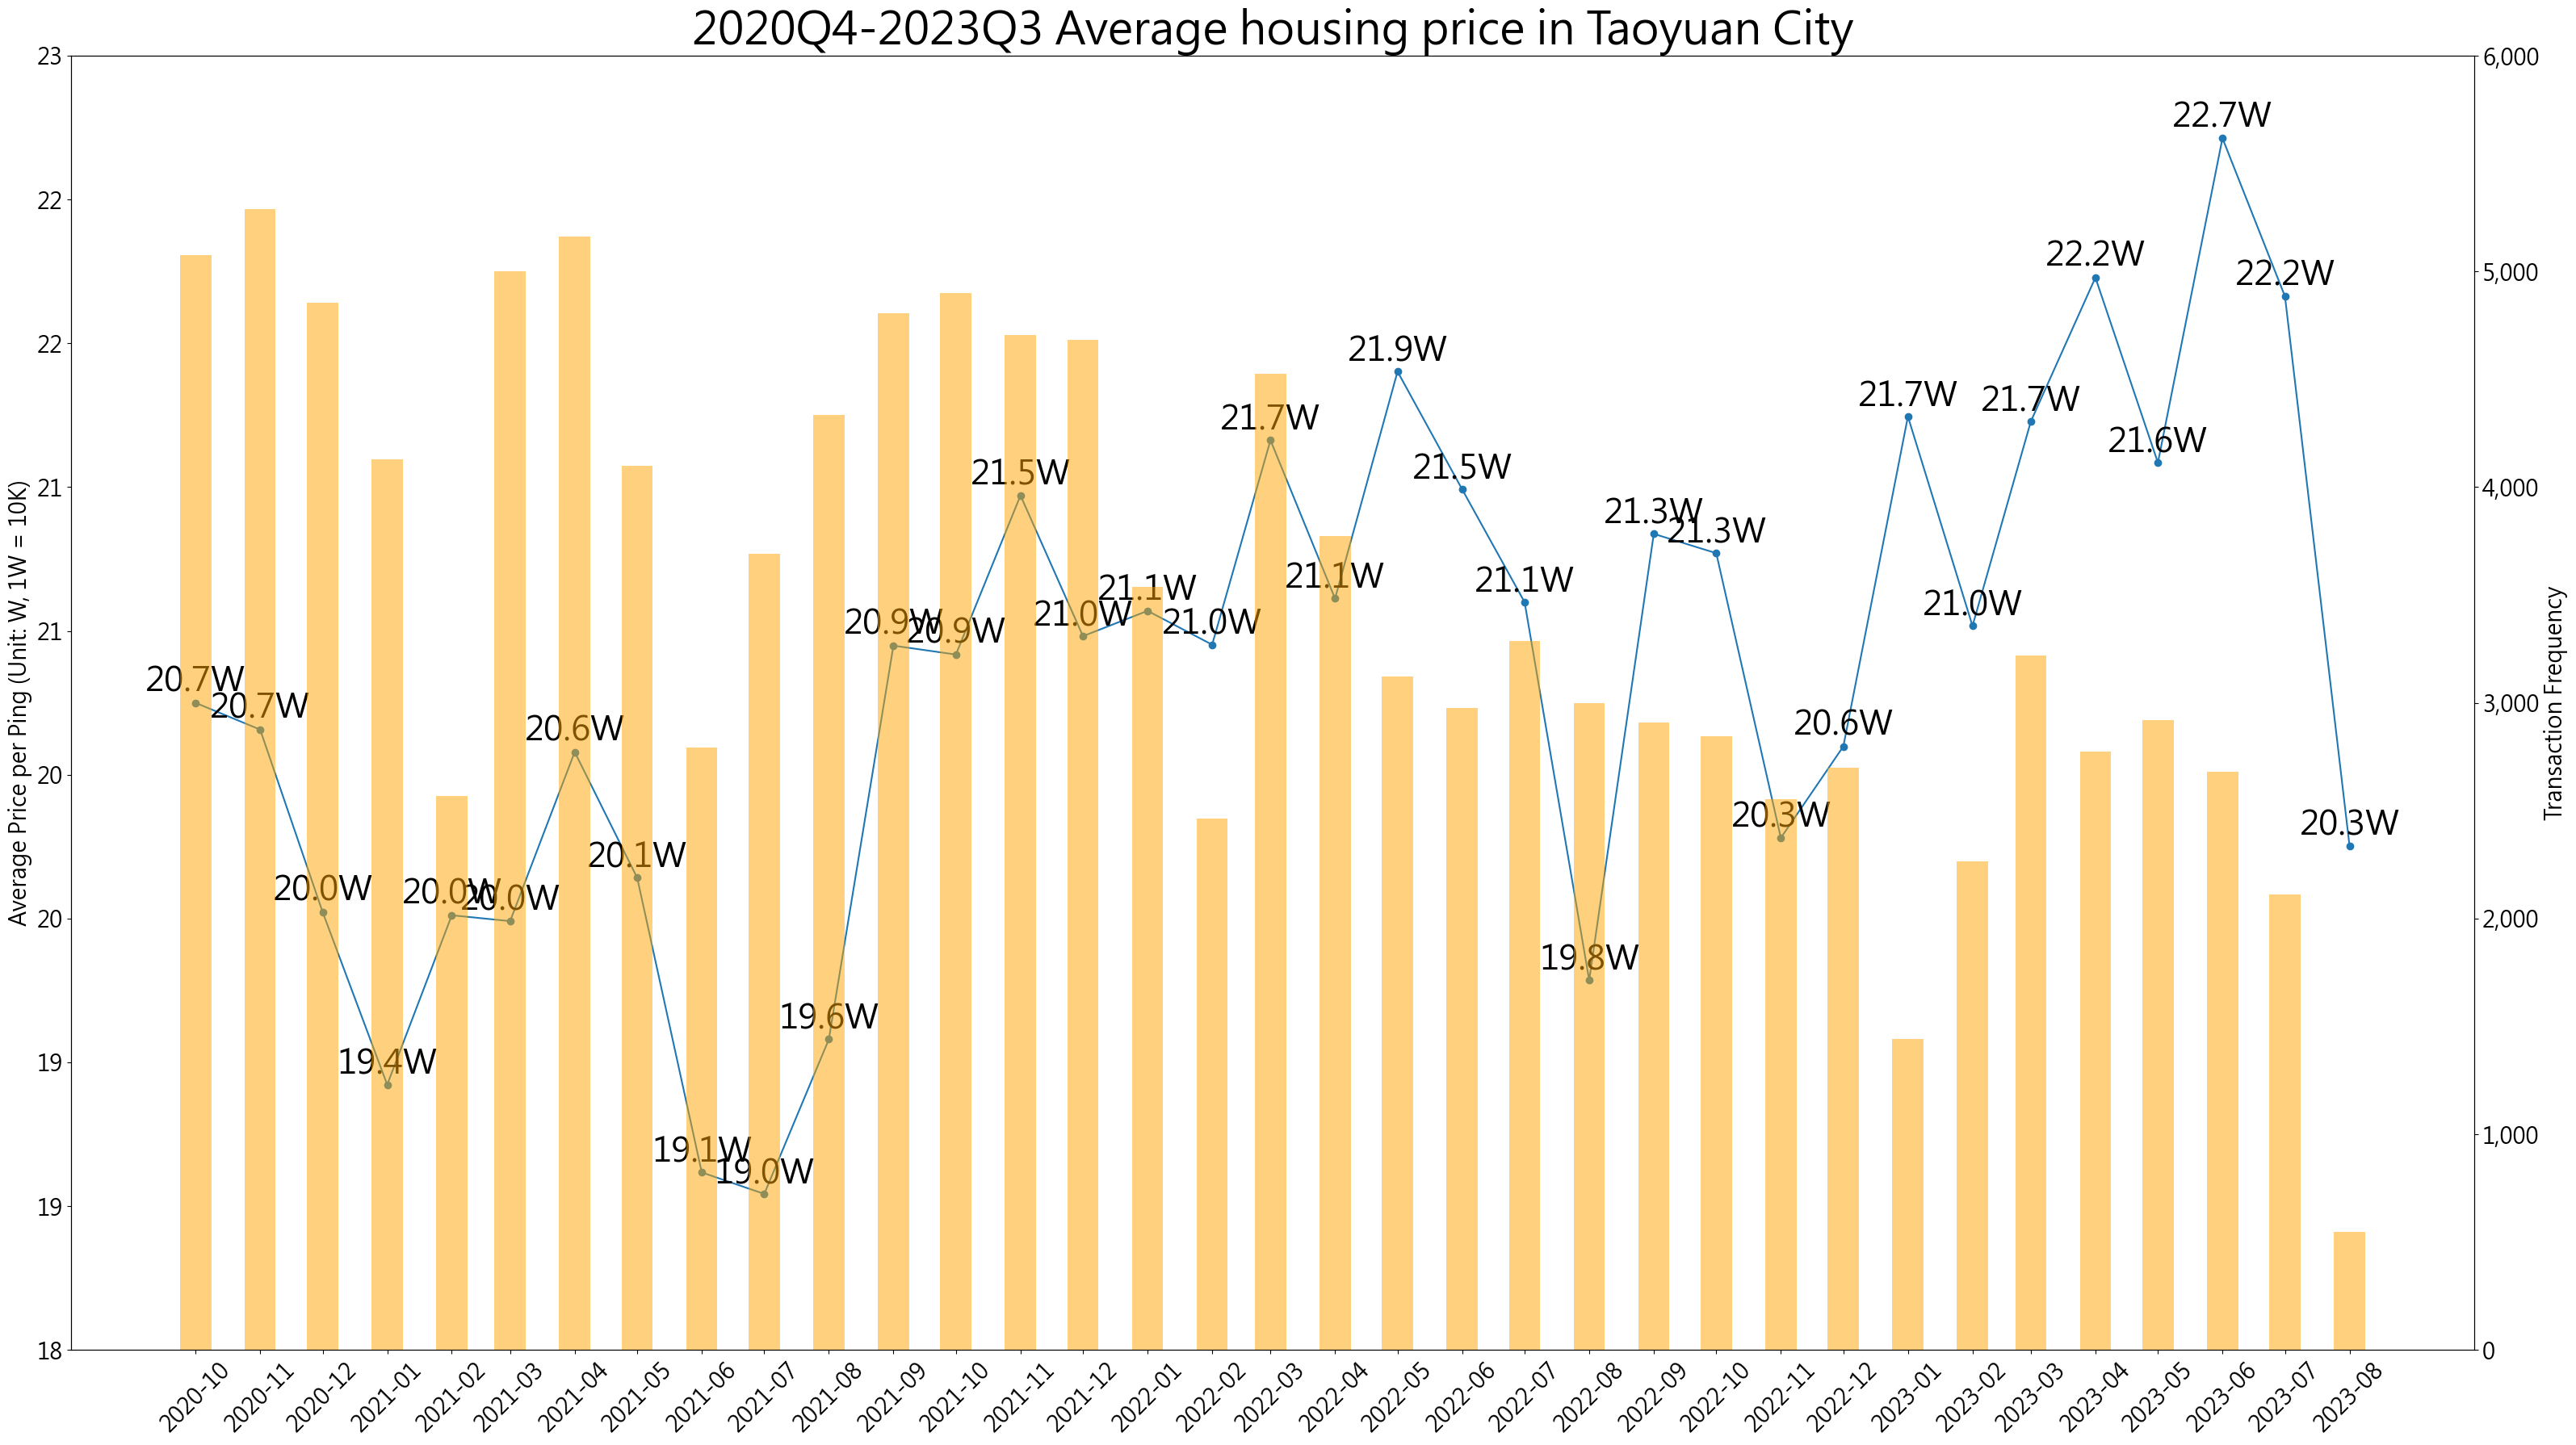

In [124]:
x_values = sorted(set(lst))
dates = [datetime.strptime(date, '%Y-%m') for date in x_values]
x_values_numeric = date2num(dates)

y = list(data.groupby(['Yearmonth'])['單價元坪'].mean())
y_values = [int(i) / 10000 for i in y]

# Count the number of entries for each unique year-month combination
entry_counts = data['Yearmonth'].value_counts().sort_index()

# Plotting
fig, ax1 = plt.subplots(figsize=(32, 18))

# Line chart
ax1.plot(x_values_numeric, y_values, marker='o', label='Average Price')

# Set the x-axis ticks to be the original date strings
ax1.set_xticks(dates)
ax1.set_xticklabels(x_values, rotation=45, fontsize=20)

# Add labels and title for the line chart
ax1.set_ylabel('Average Price per Ping (Unit: W, 1W = 10K)', fontsize=20)

# Set y-axis ticks and labels
ax1.set_yticks(ax1.get_yticks())
ax1.set_yticklabels([f'{int(i):,}' for i in ax1.get_yticks()], fontsize=20)

title = '2020Q4-2023Q3 Average housing price in Taoyuan City'
ax1.set_title(title, fontsize=40)

# Annotate the data points on the line chart
for i, txt in enumerate(y_values):
    ax1.annotate(f'{txt:.1f}W', (x_values_numeric[i], y_values[i]),
                 textcoords="offset points", xytext=(0, 10), ha='center', size=30)

# Bar chart
ax2 = ax1.twinx()  # Create a second y-axis to overlay the bar chart
ax2.bar(x_values_numeric, entry_counts, alpha=0.5, color='orange', width=15)

# Add labels and title for the bar chart
ax2.set_ylabel('Transaction Frequency', fontsize=20)

# Set y-axis ticks and labels for the second y-axis
ax2.set_yticks(ax2.get_yticks())
ax2.set_yticklabels([f'{int(i):,}' for i in ax2.get_yticks()], fontsize=20)

# Adjust layout to prevent label overlap
fig.tight_layout()


# save the plot with title named
path_to_save_file = Path().absolute()/"PNG"
path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
filename = f'{title}.png'
full_path = path_to_save_file/filename
plt.savefig(full_path)

# Show the chart
plt.show()


In [125]:
# # # # #----------------------------------------------------------------------------------------------------------------------------
data_detail = data[['總價元', '土地移轉總面積坪', '建物移轉總面積坪', '單價元坪', '主建物面積坪']]
data_detail.loc[:,'總價元'] = data_detail['總價元']/10000
data_detail.loc[:,'單價元坪'] = data_detail['單價元坪']/10000

data_detail.describe().round(2)


,總價元,土地移轉總面積坪,建物移轉總面積坪,單價元坪,主建物面積坪
count,121740.00,121740.00,121740.00,120383.00,121740.00
mean,1395.36,80.77,37.74,20.78,25.40
std,6228.47,449.55,219.26,16.60,194.98
min,0.00,0.00,0.00,0.00,0.00
25%,434.71,5.07,2.26,13.38,0.00
50%,812.12,8.39,33.45,19.99,19.35
75%,1270.00,25.61,48.30,26.49,27.31
max,630000.00,66630.27,40154.24,2119.59,39738.41


In [126]:
transaction_area = data['鄉鎮市區'].value_counts().reset_index()
transaction_area = transaction_area.sort_values(by='count', ascending=False).reset_index(drop=True)


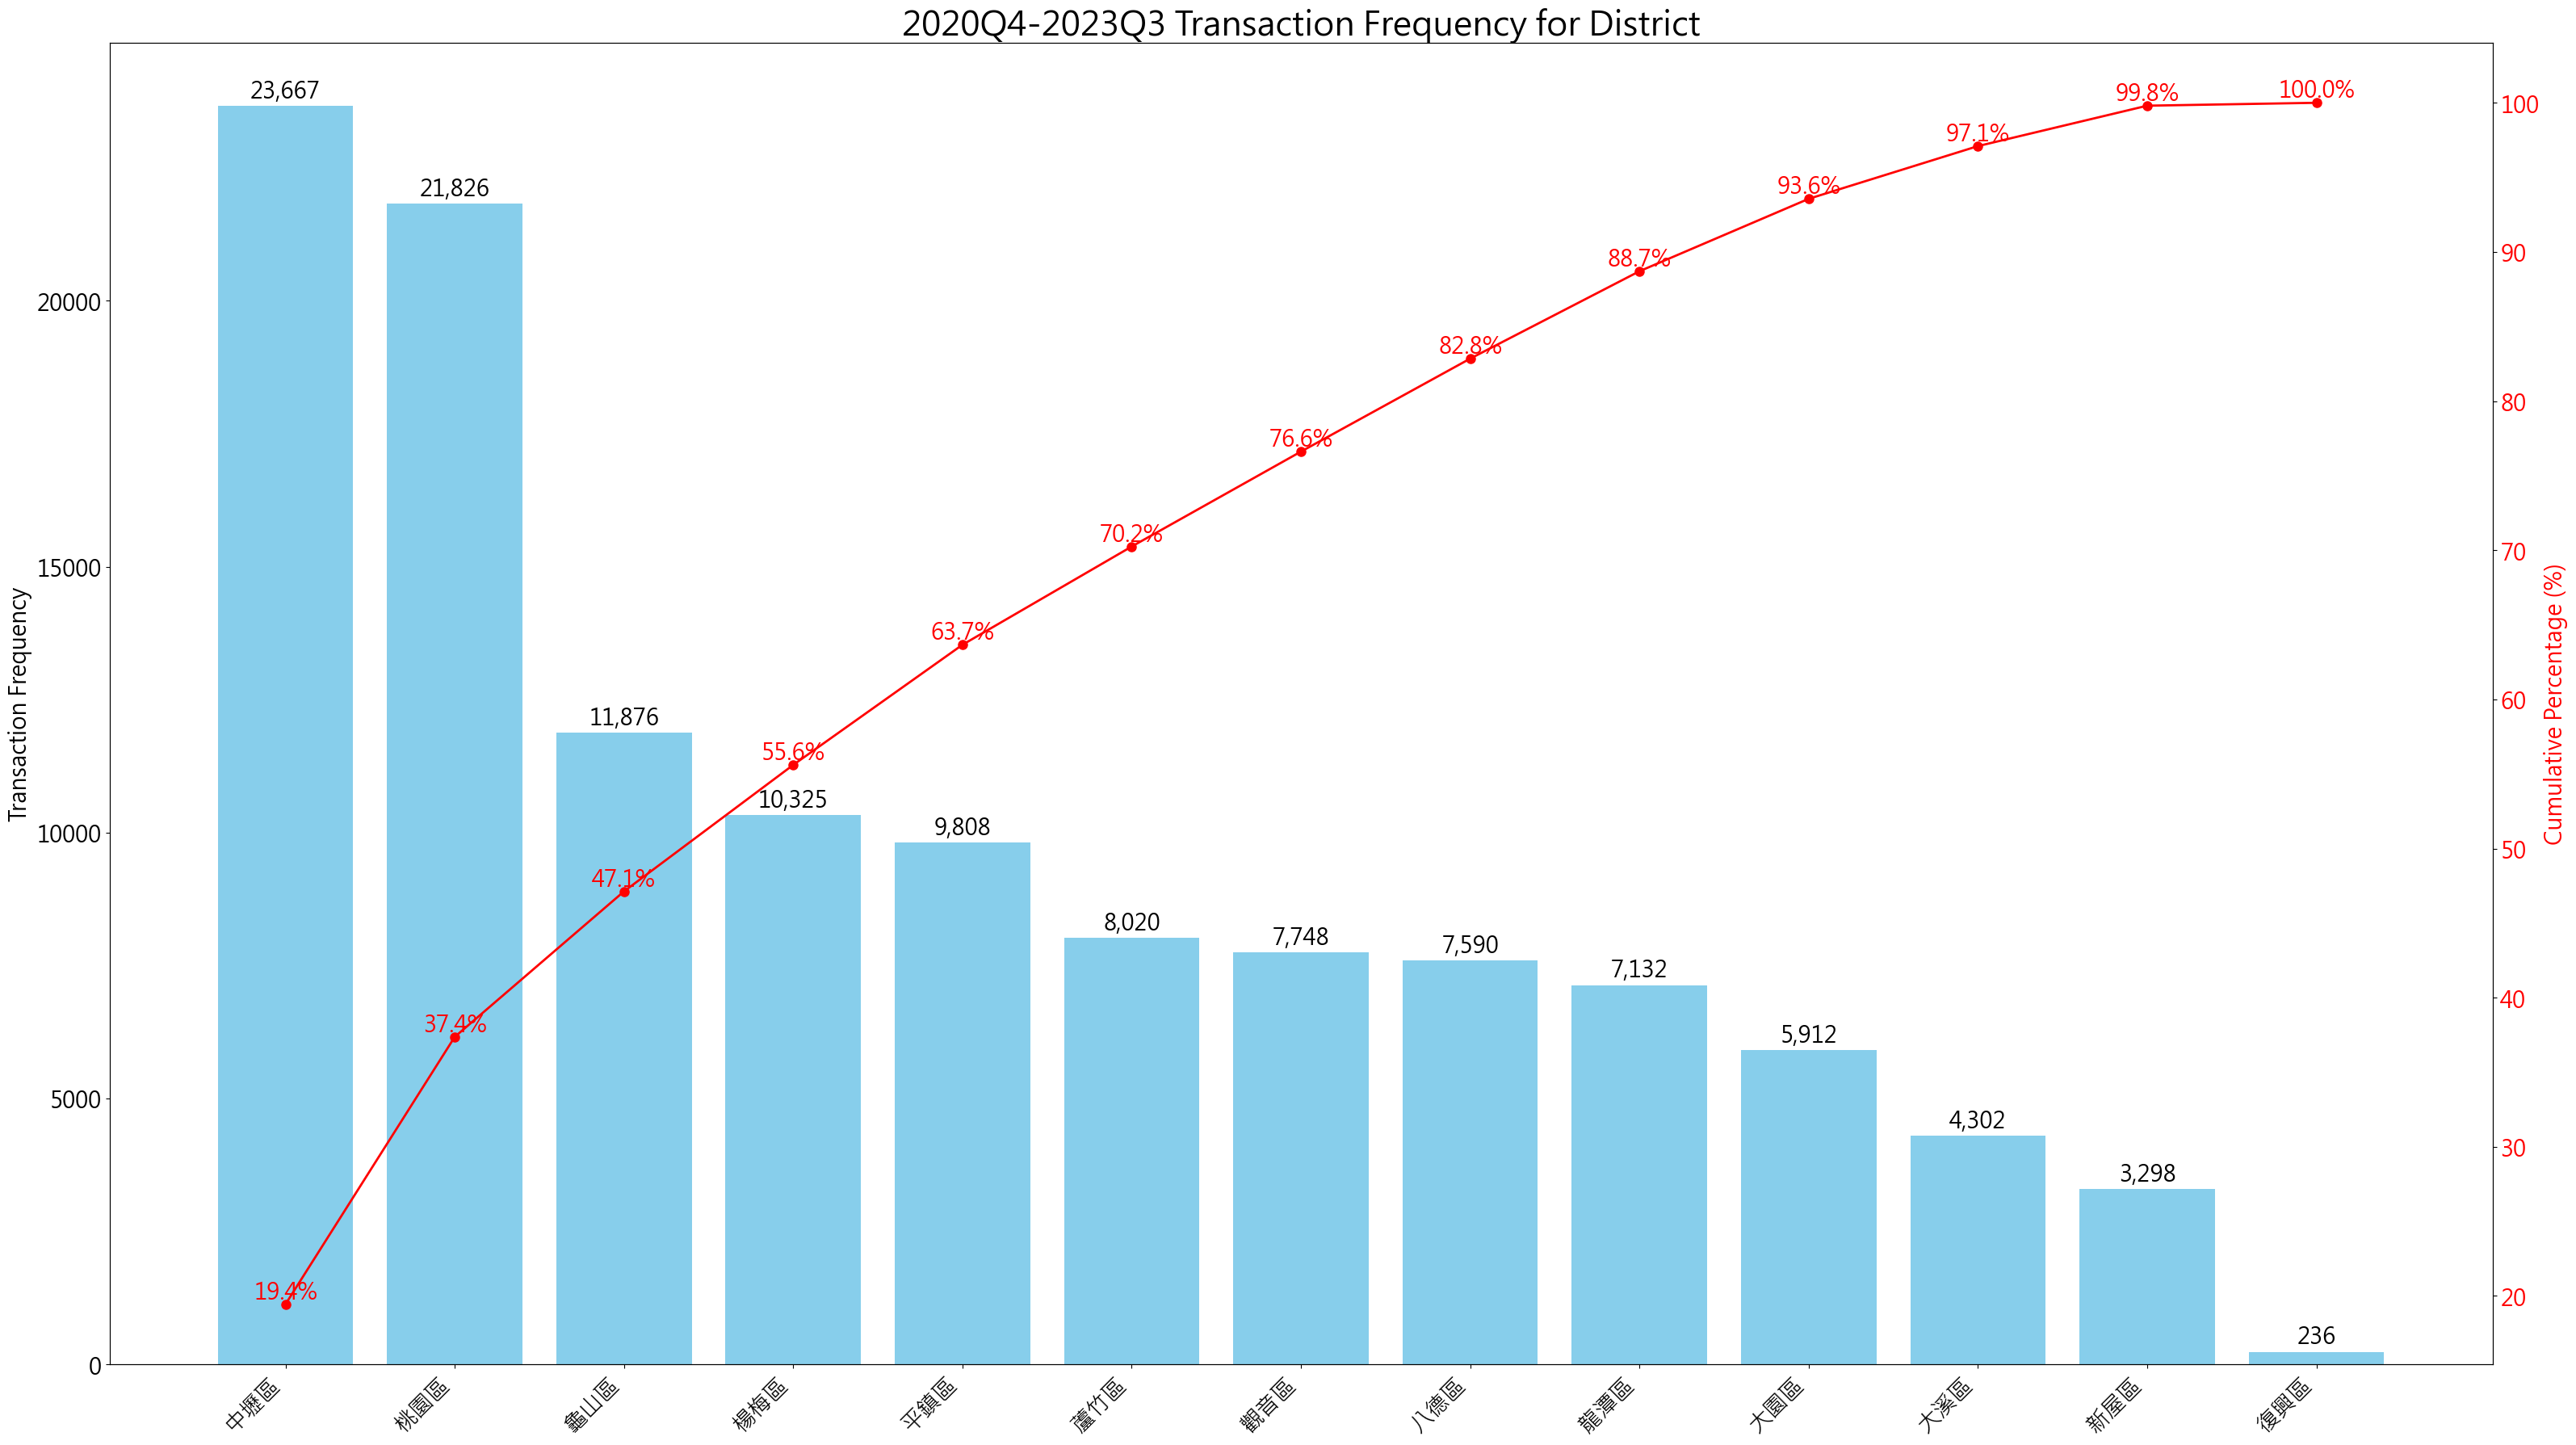

In [127]:
# Create a DataFrame
ta = pd.DataFrame(transaction_area)

# Sort DataFrame by count in descending order
ta = ta.sort_values(by='count', ascending=False)

# Calculate cumulative percentage
ta['cum_percentage'] = ta['count'].cumsum() / ta['count'].sum() * 100

# Plot the bar chart and cumulative percentage line
fig, ax1 = plt.subplots(figsize=(32, 18))
bars = ax1.bar(ta['鄉鎮市區'], ta['count'], color='skyblue')

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 50, f'{yval:,}', ha='center', va='bottom', fontsize=20)

# Add labels and title
ax1.set_ylabel('Transaction Frequency', fontsize=20)
title = '2020Q4-2023Q3 Transaction Frequency for District'
ax1.set_title(title, fontsize=30)

# Set tick positions and labels for the x-axis
ax1.set_xticks(ta.index)
ax1.set_xticklabels(ta['鄉鎮市區'], rotation=45, ha='right', fontsize=20)

ax1.tick_params(axis='y', labelsize=20)

# Create a secondary Y-axis for the cumulative percentage line
ax2 = ax1.twinx()
ax2.plot(ta.index, ta['cum_percentage'], color='red', marker='o', linestyle='-', linewidth=2, markersize=8)

# Add percentage data labels on the line
for x, y in zip(ta.index, ta['cum_percentage']):
    ax2.text(x, y, f'{y:.1f}%', ha='center', va='bottom', fontsize=20, color='red')

ax2.set_ylabel('Cumulative Percentage (%)', color='red', fontsize=20)
ax2.tick_params(axis='y', labelcolor='red', labelsize=20)

# # Show the plot
plt.tight_layout()

# # save the plot with title named
# path_to_save_file = Path().absolute()/"PNG"
# path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
# filename = f'{title}.png'
# full_path = path_to_save_file/filename
# plt.savefig(full_path)

plt.show()


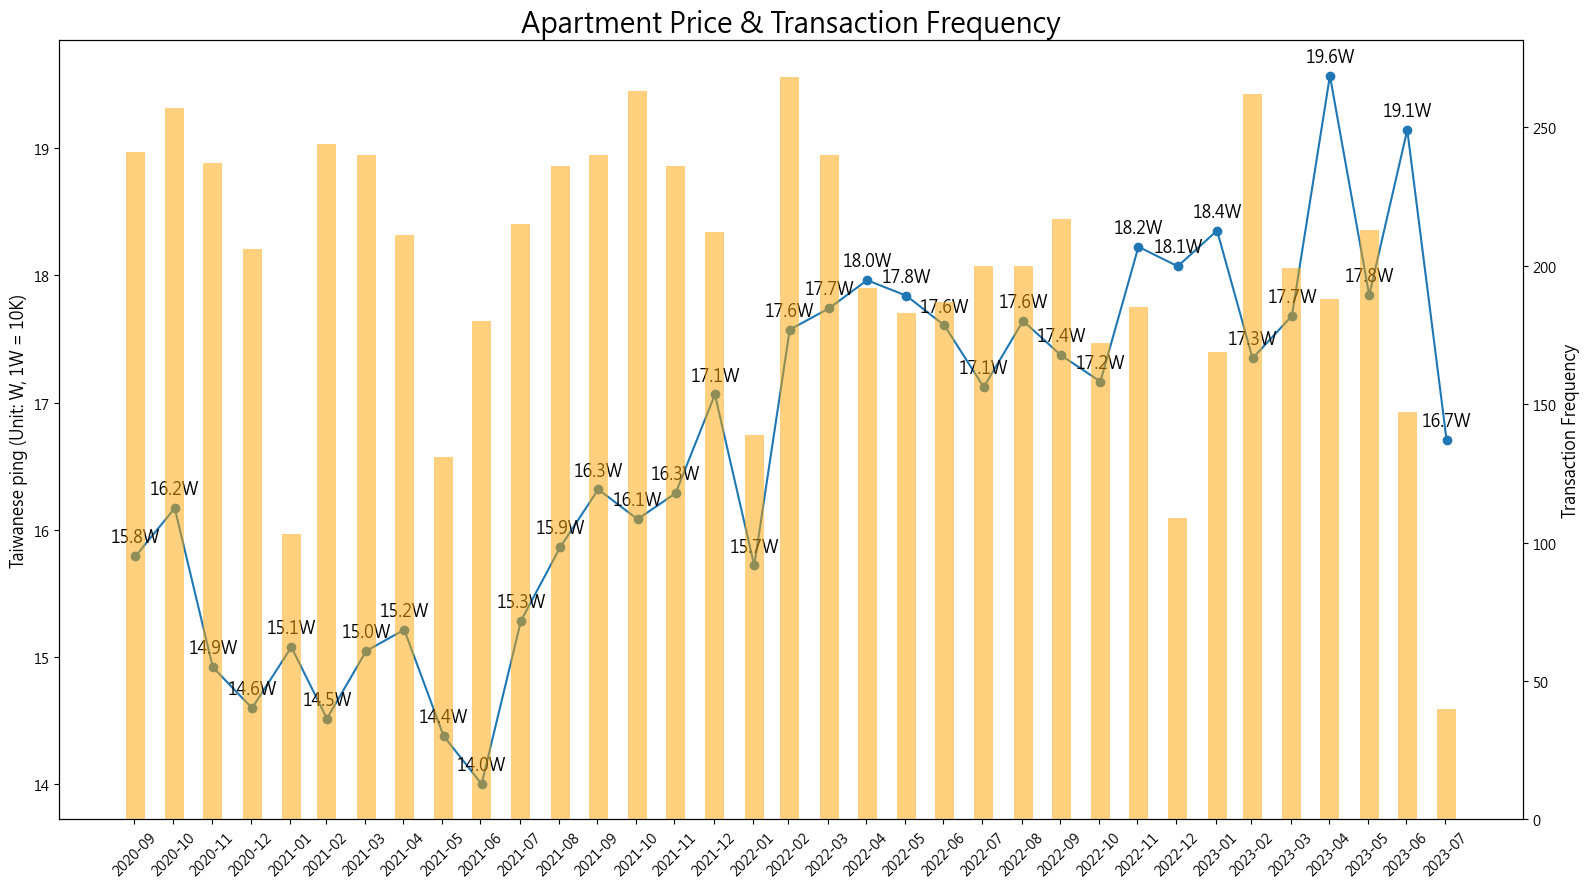

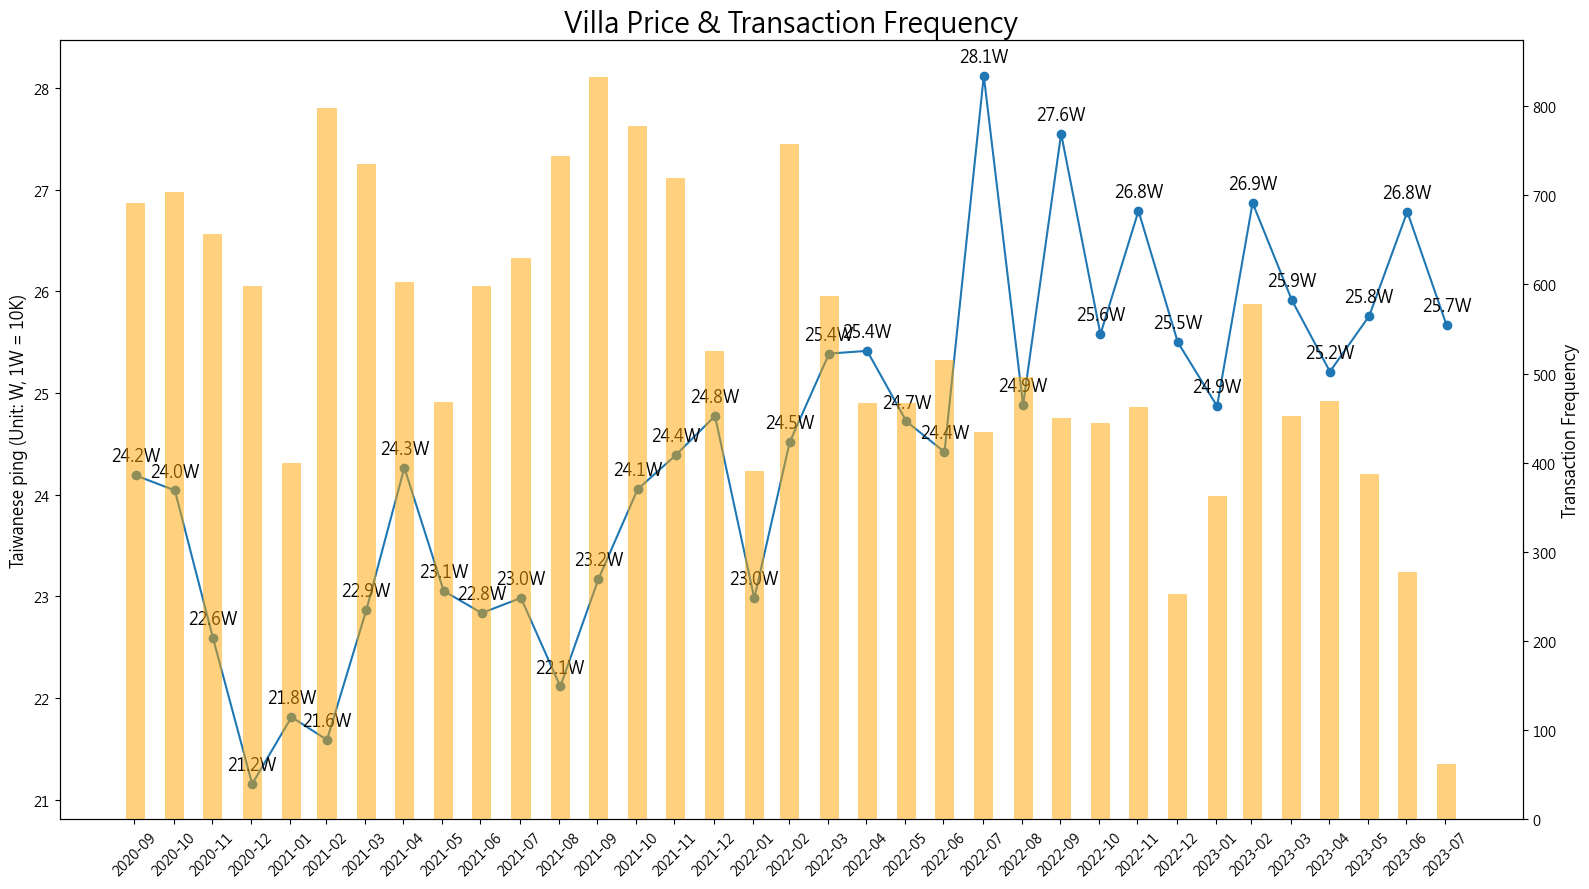

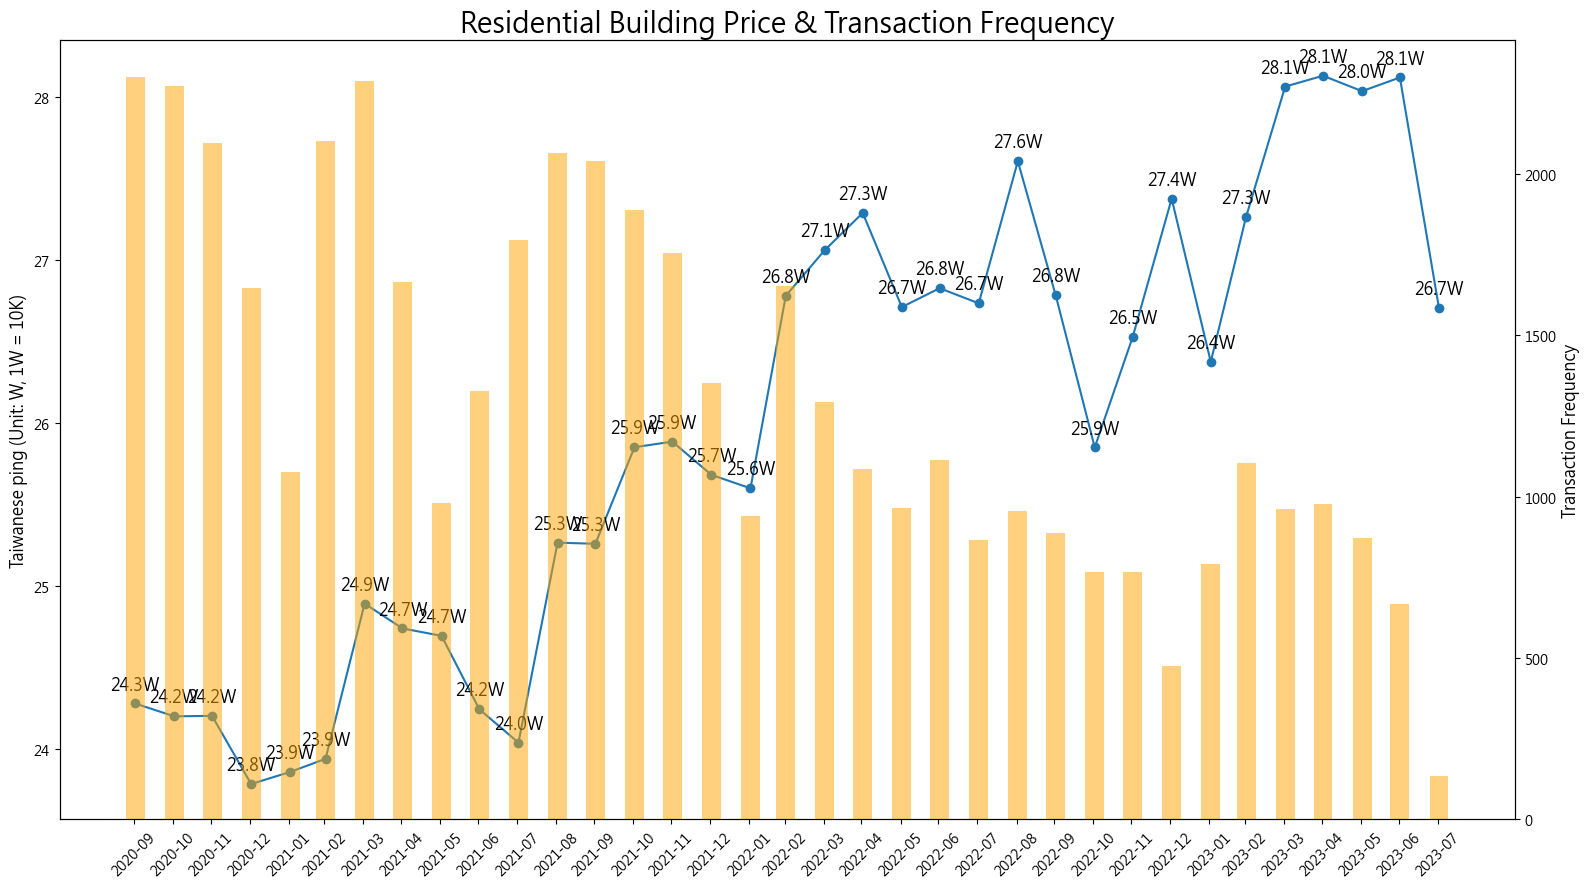

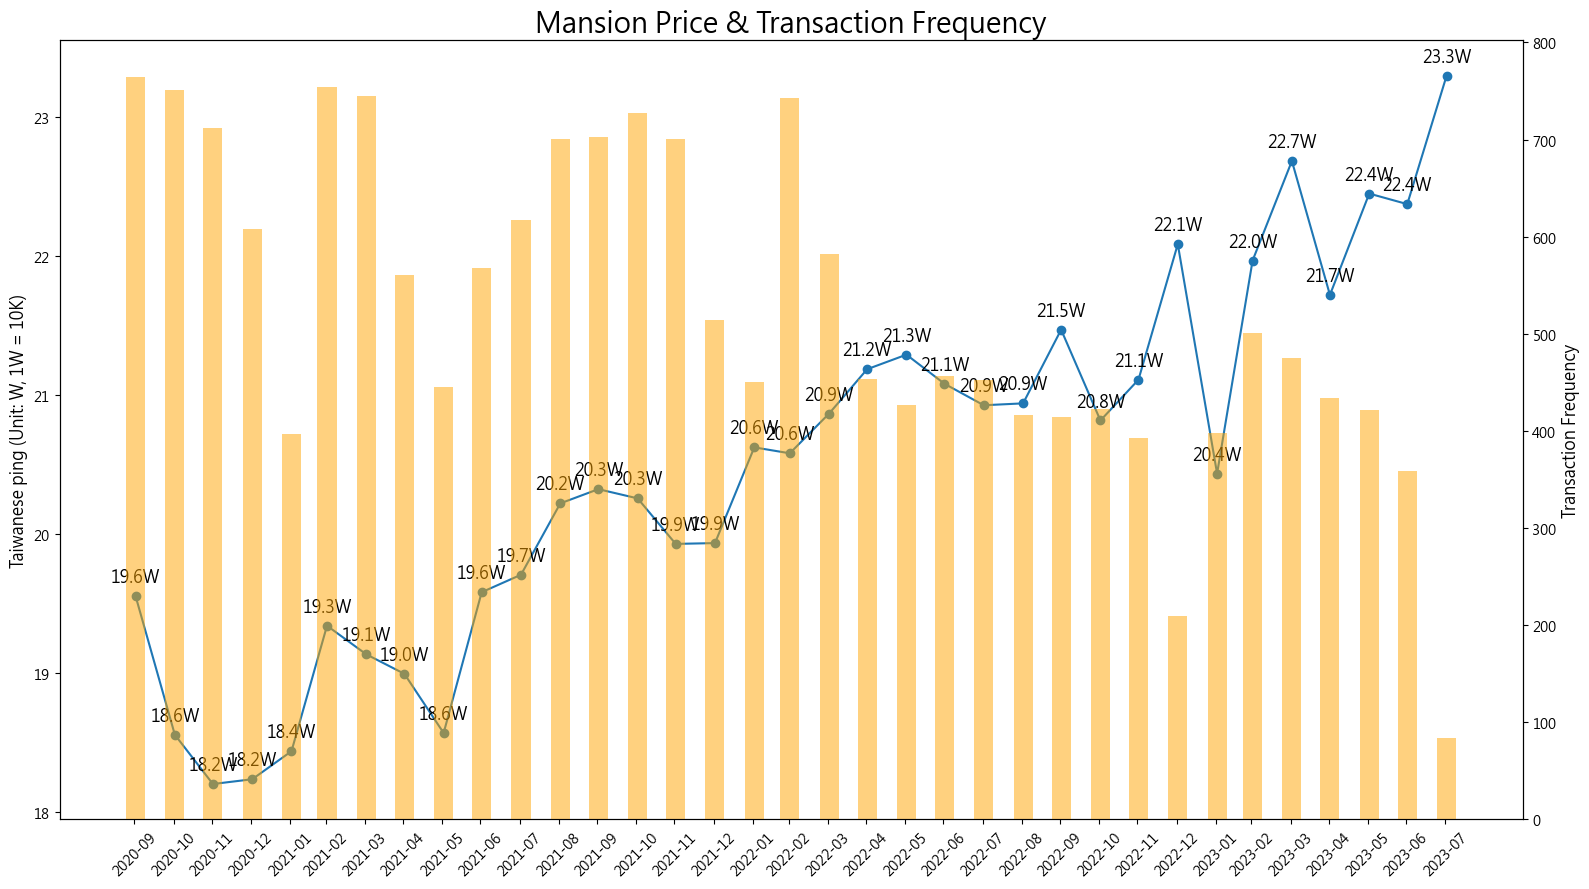

In [128]:
# Create a new DataFrame 'data2'
data2 = pd.DataFrame(data.groupby(['建物型態', 'Yearmonth'])['單價元坪'].mean()).reset_index()
data2['單價元坪'] = data2['單價元坪'] / 10000
property_dict = {'公寓(5樓含以下無電梯)': 'Apartment', 
                 '透天厝': 'Villa', 
                 '住宅大樓(11層含以上有電梯)': 'Residential Building', 
                 '華廈(10層含以下有電梯)':'Mansion'}

type_n = 0
for type in property_dict.keys():
    # Create a copy of data2
    data2_copy = data2[data2['建物型態'] == type]

    # Convert the Yearmonth column to datetime
    data2_copy.loc[:, 'Yearmonth'] = pd.to_datetime(data2_copy['Yearmonth'].astype(str), format='%Y-%m')

    # Sort the data by Yearmonth
    data2_copy = data2_copy.sort_values(by='Yearmonth')

    # Create a figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(16, 9))

    # Line chart for average price
    ax1.plot(data2_copy['Yearmonth'], data2_copy['單價元坪'], marker='o', linestyle='-', label='Average Price')
    ax1.set_ylabel('Taiwanese ping (Unit: W, 1W = 10K)', fontsize=12)
    title = f'{list(property_dict.values())[type_n]} Price & Transaction Frequency'
    type_n += 1
    ax1.set_title(title, fontsize=20)
    ax1.tick_params(axis='x', labelrotation=45)

    # Annotate the data points on the line chart with data labels
    for i, txt in enumerate(data2_copy['單價元坪']):
        ax1.annotate(f'{txt:.1f}W', (data2_copy['Yearmonth'].iloc[i], data2_copy['單價元坪'].iloc[i]),
                     textcoords="offset points", xytext=(0, 10), ha='center', size=12)

    # Create a second y-axis for the bar chart
    ax2 = ax1.twinx()
    
    # Bar chart for entry counts
    entry_counts = data[data['建物型態'] == type]['Yearmonth'].value_counts().sort_index()
    ax2.bar(data2_copy['Yearmonth'], entry_counts, alpha=0.5, color='orange', width=15, label='Entry Counts')
    ax2.set_ylabel('Transaction Frequency', fontsize=12)

    # Set the x-axis ticks and labels to display from September 2020 to August 2023
    ax1.set_xticks(pd.date_range('2020-09-01', '2023-08-01', freq='M'))
    ax1.set_xticklabels([date.strftime('%Y-%m') for date in pd.date_range('2020-09-01', '2023-08-01', freq='M')],
                        rotation=45)

    # Adjust layout to prevent label overlap
    fig.tight_layout()

    # # save the plot with title named
    # path_to_save_file = Path().absolute()/"PNG"/"Type"
    # path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
    # filename = f'{title}.png'
    # full_path = path_to_save_file/filename
    # plt.savefig(full_path)

    # Show the chart
    plt.show()

In [129]:
data_count = data['建物型態'].value_counts()
data_count = pd.DataFrame(data_count).reset_index()
data_count['Weight'] = ((data_count['count'] / data_count['count'].sum())*100).round(2)
data_count['建物型態'] = data_count['建物型態'].replace(property_dict)
data_count['Weight'] = data_count['Weight'].apply(lambda x: f'{x}%')
data_count = data_count.rename(columns={'建物型態': 'Property Type'})
data_count


,Property Type,count,Weight
0,Residential Building,45930,37.73%
1,其他,31689,26.03%
2,Villa,18792,15.44%
3,Mansion,18360,15.08%
4,Apartment,6962,5.72%
5,廠辦,3,0.0%
6,店面(店鋪),3,0.0%
7,工廠,1,0.0%


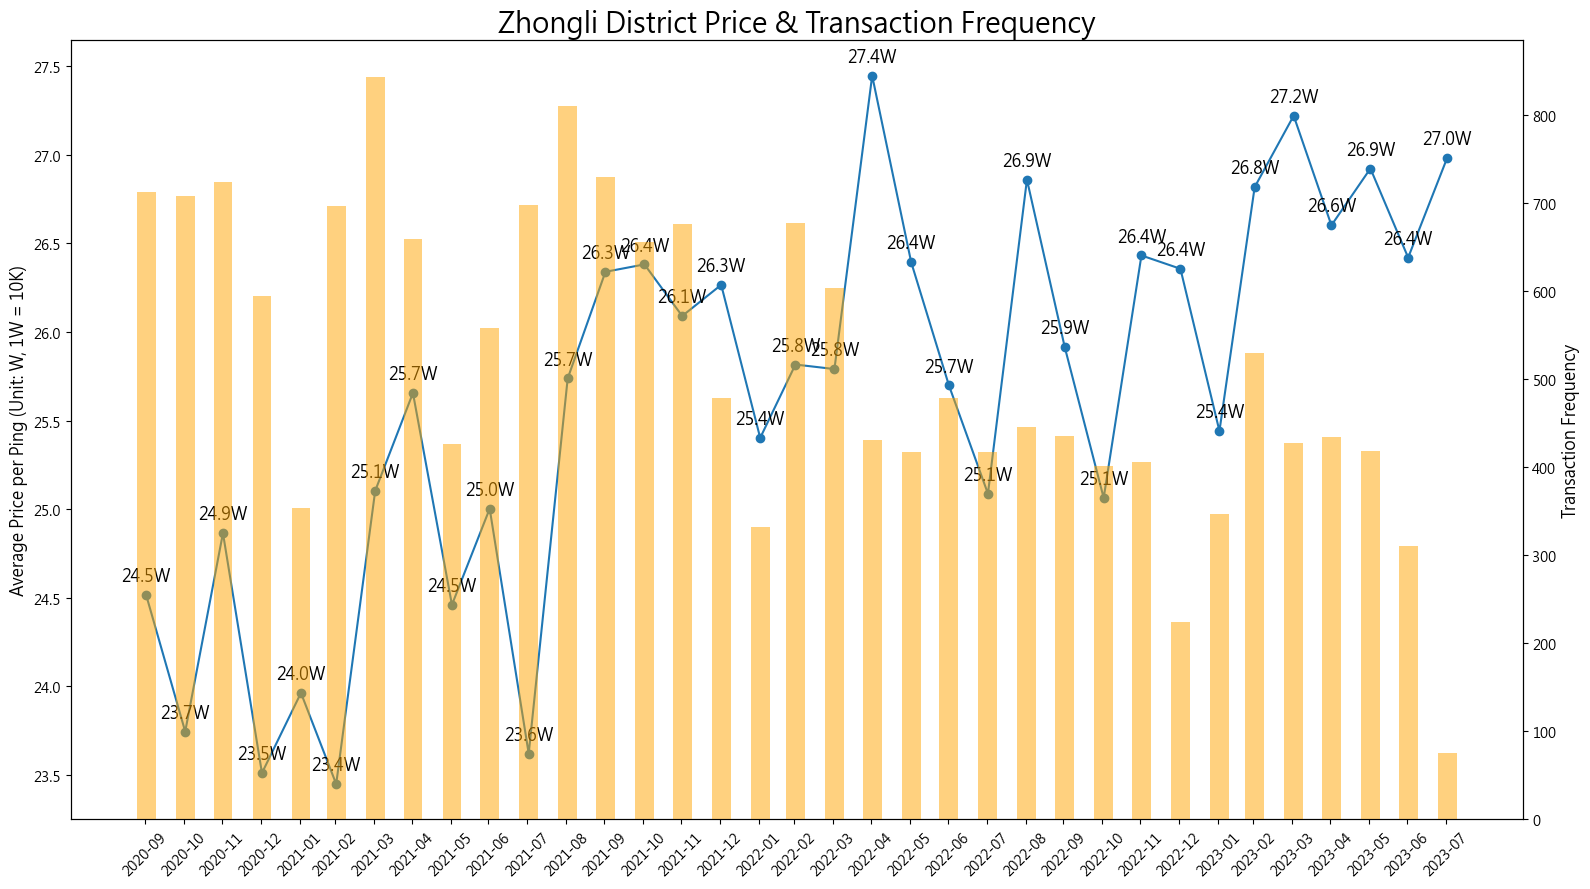

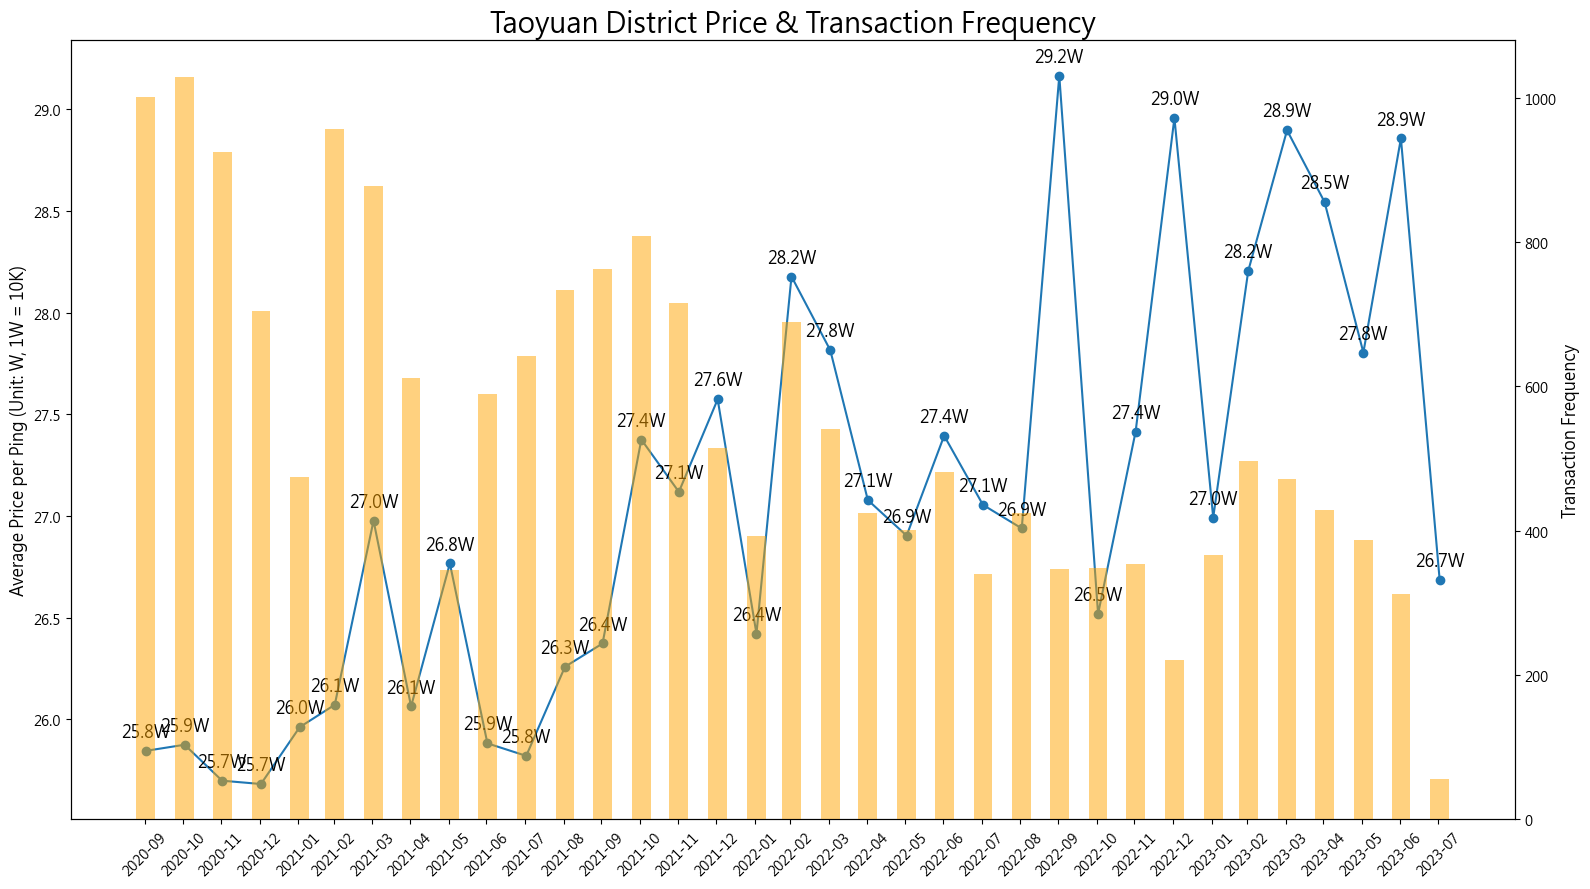

In [130]:
data = data[(data['建物型態'] == '公寓(5樓含以下無電梯)') | (data['建物型態'] == '透天厝') | (data['建物型態'] == '住宅大樓(11層含以上有電梯)') | (data['建物型態'] == '華廈(10層含以下有電梯)')]

# Create a new DataFrame 'data3'
data3 = pd.DataFrame(data.groupby(['鄉鎮市區', 'Yearmonth'])['單價元坪'].mean()).reset_index()
data3['單價元坪'] = data3['單價元坪'] / 10000
dist_dict = {'大溪區': 'Daxi District',
             '楊梅區': 'Yangmei District',
             '龍潭區': 'Longtan District',
             '平鎮區': 'Pingzhen District',
             '觀音區': 'Guanyin District',
             '蘆竹區': 'Luzhu District',
             '桃園區': 'Taoyuan District',
             '八德區': 'Bade District',
             '龜山區': 'Guishan District',
             '大園區': 'Dayuan District',
             '中壢區': 'Zhongli District',
             '新屋區': 'Xinwu District'}

for area in ['中壢區', '桃園區']:
    # Create a copy of data3
    data3_copy = data3.copy()
    
    # Filter data for the specific district
    data3_copy = data3_copy[data3_copy['鄉鎮市區'] == area]

    # Convert the Yearmonth column to datetime
    data3_copy['Yearmonth'] = pd.to_datetime(data3_copy['Yearmonth'].astype(str), format='%Y-%m')

    # Sort the data by Yearmonth
    data3_copy = data3_copy.sort_values(by='Yearmonth')

    # Create a figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(16, 9))

    # Line chart for average price
    ax1.plot(data3_copy['Yearmonth'], data3_copy['單價元坪'], marker='o', linestyle='-', label='Average Price')
    ax1.set_ylabel('Average Price per Ping (Unit: W, 1W = 10K)', fontsize=12)
    title = f'{dist_dict.get(area)} Price & Transaction Frequency'
    ax1.set_title(title, fontsize=20)
    ax1.tick_params(axis='x', labelrotation=45)

    # Create a second y-axis for the bar chart
    ax2 = ax1.twinx()
    
    # Bar chart for transaction counts
    entry_counts = data[data['鄉鎮市區'] == area]['Yearmonth'].value_counts().sort_index()
    ax2.bar(data3_copy['Yearmonth'], entry_counts, alpha=0.5, color='orange', width=15, label='Transaction Counts')
    ax2.set_ylabel('Transaction Frequency', fontsize=12)

    # Set the x-axis ticks and labels to display from September 2020 to August 2023
    ax1.set_xticks(pd.date_range('2020-09-01', '2023-08-01', freq='M'))
    ax1.set_xticklabels([date.strftime('%Y-%m') for date in pd.date_range('2020-09-01', '2023-08-01', freq='M')],
                        rotation=45)

    # Annotate the data points on the line chart with data labels
    for i, txt in enumerate(data3_copy['單價元坪']):
        ax1.annotate(f'{txt:.1f}W', (data3_copy['Yearmonth'].iloc[i], data3_copy['單價元坪'].iloc[i]),
                     textcoords="offset points", xytext=(0, 10), ha='center', size=12)

    # Adjust layout to prevent label overlap
    fig.tight_layout()

    # save the plot with title named
    path_to_save_file = Path().absolute()/"PNG"/"District"
    path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
    filename = f'{title}.png'
    full_path = path_to_save_file/filename
    plt.savefig(full_path)

    # Show the chart
    plt.show()


In [30]:


import math

# 初始化一個空的 DataFrame
result_data_Zh_Tao = pd.DataFrame(columns=['Type', '鄉鎮市區', '2020Q4 avg price', '2023Q2 avg price', 'Growth Difference'])

for type in list(property_dict.keys()):
    # Step 1: 篩選出建物型態為住宅大樓的數據
    residential_df = data_Zh_Tao[data_Zh_Tao['建物型態'] == type]

    # Step 2: 提取鄉鎮市區值
    district_value = residential_df['鄉鎮市區'].iloc[0]

    # Step 3: 計算2020年第四季和2023年第二季的平均價格
    avg_price_2020_Q4 = residential_df[(residential_df['Year'] == 2020) & (residential_df['Quarter'] == 4)]['單價元坪'].mean() / 10000
    avg_price_2023_Q2 = residential_df[(residential_df['Year'] == 2023) & (residential_df['Quarter'] == 2)]['單價元坪'].mean() / 10000

    # 轉換為小數點兩位
    avg_price_2020_Q4 = round(avg_price_2020_Q4, 2)
    avg_price_2023_Q2 = round(avg_price_2023_Q2, 2)

    # Step 4: 計算成長差異
    if not math.isnan(avg_price_2023_Q2):
        price_growth_difference = ((avg_price_2023_Q2 - avg_price_2020_Q4) / avg_price_2023_Q2) * 100

        # 轉換成百分比，並且保留小數點兩位
        price_growth_difference = round(price_growth_difference, 2)

        # Step 5: 檢查 Growth difference 是否為 NaN，如果不是，加入到 DataFrame
        if not math.isnan(price_growth_difference):
            # 檢查是否為空的 DataFrame
            if result_data_Zh_Tao.empty:
                result_data_Zh_Tao = pd.DataFrame([{
                    'Type': property_dict.get(type),
                    '鄉鎮市區': district_value,
                    '2020Q4 avg price': avg_price_2020_Q4,
                    '2023Q2 avg price': avg_price_2023_Q2,
                    'Growth Difference': f"{price_growth_difference}%"
                }])
            else:
                # 合併非空的 DataFrame
                result_data_Zh_Tao = pd.concat([result_data_Zh_Tao, pd.DataFrame([{
                    'Type': property_dict.get(type),
                    '鄉鎮市區': district_value,
                    '2020Q4 avg price': avg_price_2020_Q4,
                    '2023Q2 avg price': avg_price_2023_Q2,
                    'Growth Difference': f"{price_growth_difference}%"
                }])], ignore_index=True)

# 輸出最終的 DataFrame
result_data_Zh_Tao = result_data_Zh_Tao[['Type', '鄉鎮市區', '2020Q4 avg price', '2023Q2 avg price', 'Growth Difference']]
result_data_Zh_Tao


,Type,鄉鎮市區,2020Q4 avg price,2023Q2 avg price,Growth Difference
0,Apartment,中壢區,18.15,20.21,10.19%
1,Villa,中壢區,28.46,32.44,12.27%
2,Residential Building,桃園區,26.47,29.67,10.79%
3,Mansion,桃園區,19.61,23.27,15.73%


In [131]:
data_Zh_Tao = data[(data['鄉鎮市區'] == '中壢區') | (data['鄉鎮市區'] == '桃園區')]

# 先筛选出 2020Q4 和 2023Q2 的数据
selected_df = data_Zh_Tao[(data_Zh_Tao['Year'].isin([2020, 2023])) & (data_Zh_Tao['Quarter'].isin([4, 2]))]

# 使用 pivot_table 计算平均值，同时按照 Type 分组
pivot_df = pd.pivot_table(selected_df, values='單價元坪', index=['鄉鎮市區', '建物型態'], columns=['Year', 'Quarter'], aggfunc='mean')

# 计算 Growth Difference
pivot_df['Growth Difference'] = ((pivot_df[2023][2] - pivot_df[2020][4]) / pivot_df[2020][4] * 100).round(2).astype(str) + '%'

# 重置索引
pivot_df.reset_index(inplace=True)

# 添加 Type 列，根据鄉鎮市區的值设定 Type
pivot_df['Type'] = pivot_df['鄉鎮市區'].apply(lambda x: '中壢區' if x == '中壢區' else '桃園區')

# 重新排列列的顺序
pivot_df = pivot_df[['Type', '建物型態', 2020, 2023, 'Growth Difference']]

# 重命名列
pivot_df.columns = ['Area', 'Type', '2020Q4 avg price', '2023Q2 avg price', 'Growth Difference']

pivot_df['Area'] = pivot_df['Area'].replace(dist_dict)
pivot_df['Type'] = pivot_df['Type'].replace(property_dict)
pivot_df['2020Q4 avg price'] = pivot_df['2020Q4 avg price']/10000
pivot_df['2023Q2 avg price'] = pivot_df['2023Q2 avg price']/10000

# 打印输出
pivot_df.round(2)


,Area,Type,2020Q4 avg price,2023Q2 avg price,Growth Difference
0,Zhongli District,Residential Building,26.04,29.39,12.84%
1,Zhongli District,Apartment,18.33,19.96,8.87%
2,Zhongli District,Mansion,17.92,22.97,28.23%
3,Zhongli District,Villa,27.40,31.10,13.52%
4,Taoyuan District,Residential Building,26.71,29.86,11.78%
5,Taoyuan District,Apartment,17.90,20.62,15.19%
6,Taoyuan District,Mansion,21.10,23.67,12.2%
7,Taoyuan District,Villa,31.00,35.23,13.64%


In [132]:
## Export file as CSV
# path_to_save_file = Path().absolute()/"CSV"
# filename = '2020Q3-2023Q3_Taoyaun_property_data.csv' # save the plot with title named
# full_path = path_to_save_file/filename  # Constructing the full path

# data.to_csv(full_path, index=False)


In [146]:
# 針對青埔特區作分析
# 要搜尋的多個關鍵字
keywords = ['青芝段', '青山段', '青溪段', '青昇段', '青平段', '青峰段', '領航南路', '領航北路', '公園路二段', '公園路一段', '洽溪路', '青埔路',
            '文智路', '文興路', '致遠一路', '致祥三街', '致祥一街', '吉園路', '青境路', '青昇路', '青昇一街', '青峰路二段', '大成路一段', '高鐵北路二段',
            '大勇路', '大華一街', '大華二街', '領航北路三段', '明德街', '興德路', '永園路二段']

# 在"土地位置建物門牌"欄位中找到包含特定關鍵字的資料
data_HSR = data[(data['鄉鎮市區'] == '中壢區') | (data['鄉鎮市區'] == '大園區') | (data['建物型態'] == '公寓(5樓含以下無電梯)') | (data['建物型態'] == '透天厝') | (data['建物型態'] == '住宅大樓(11層含以上有電梯)') | (data['建物型態'] == '華廈(10層含以下有電梯)')]

property_dict = {'公寓(5樓含以下無電梯)': 'Apartment', 
                 '透天厝': 'Villa', 
                 '住宅大樓(11層含以上有電梯)': 'Residential Building', 
                 '華廈(10層含以下有電梯)':'Mansion'}

# 在"土地位置建物門牌"欄位中找到包含多個關鍵字的資料
data_HSR = data_HSR[data_HSR['土地位置建物門牌'].str.contains('|'.join(keywords), na=False)]
data_HSR_detail = data_HSR[['土地移轉總面積平方公尺', '總價元', '主建物面積坪', '土地移轉總面積坪', '建物移轉總面積坪', '單價元坪']]
data_HSR_detail.loc[:,'總價元'] = data_HSR_detail['總價元'] / 10000
data_HSR_detail.loc[:,'單價元坪'] = data_HSR_detail['單價元坪'] / 10000

# data_HSR.describe()
np.round(data_HSR_detail, decimals = 2)
# data_HSR_detail.describe().round(2)


,土地移轉總面積平方公尺,總價元,主建物面積坪,土地移轉總面積坪,建物移轉總面積坪,單價元坪
297,34.84,1828.0,35.04,10.54,76.17,24.00
303,10.4,568.0,15.77,3.15,24.91,22.80
475,31.46,1070.0,23.36,9.52,47.47,22.54
483,27.01,950.0,24.88,8.17,47.94,19.82
640,21.73,1530.0,23.68,6.57,48.83,31.33
...,...,...,...,...,...,...
12107,34.48,1331.0,24.59,10.43,53.92,29.30
12108,34.48,1386.0,24.59,10.43,53.92,30.15
12109,34.48,1353.0,24.59,10.43,53.92,29.60
12111,35.14,1483.0,24.59,10.63,66.51,29.60


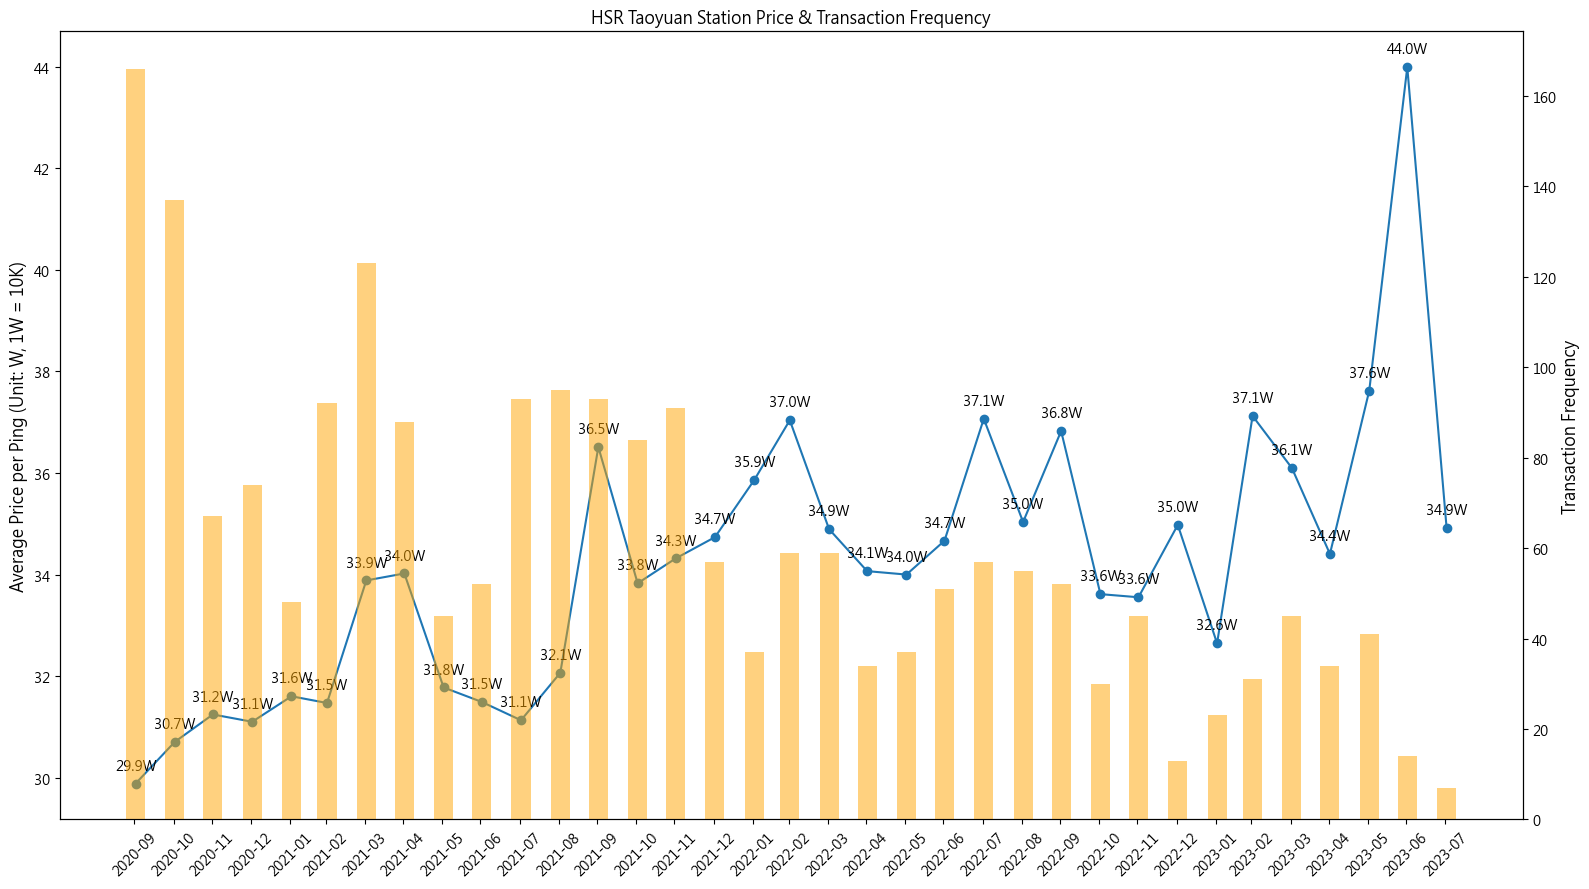

In [147]:
# Convert 'Yearmonth' to datetime
data_HSR['Yearmonth'] = pd.to_datetime(data_HSR['Yearmonth'].astype(str), errors='coerce')

# Drop rows with missing or NaT values (if needed)
data_bigger = data_HSR.dropna(subset=['Yearmonth'])

# Continue with the rest of your code...
average_price_per_sqm = data_bigger.groupby('Yearmonth')['單價元坪'].mean().reset_index()

# Convert 'Yearmonth' values to numeric
average_price_per_sqm = data_HSR.groupby('Yearmonth')['單價元坪'].mean().reset_index()
x_values = sorted(set(average_price_per_sqm['Yearmonth']))
x_values_numeric = date2num(x_values)

# Calculate transaction counts per month
entry_counts = data_HSR['Yearmonth'].value_counts().sort_index().reset_index()
entry_counts.columns = ['Yearmonth', 'Transaction Counts']

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(16, 9))

# 繪製平均價格的折線圖
line = ax1.plot(x_values_numeric, average_price_per_sqm['單價元坪'] / 10000, marker='o', label='Average Price')
ax1.set_ylabel('Average Price per Ping (Unit: W, 1W = 10K)', fontsize=12)
ax1.tick_params('y')

# 設定圖表標題和軸標籤
title = 'HSR Taoyuan Station Price & Transaction Frequency'
plt.title(title)

# 設定雙 Y 軸
ax2 = ax1.twinx()
ax2.bar(x_values_numeric, entry_counts['Transaction Counts'], alpha=0.5, color='orange', width=15, label='Transaction Counts')
ax2.set_ylabel('Transaction Frequency', fontsize=12)

# Set the x-axis ticks and labels to display from September 2020 to August 2023
ax1.set_xticks(pd.date_range('2020-09-01', '2023-08-01', freq='M'))
ax1.set_xticklabels([date.strftime('%Y-%m') for date in pd.date_range('2020-09-01', '2023-08-01', freq='M')],
                    rotation=45)

# Add data labels to the line plot
for i, txt in enumerate(average_price_per_sqm['單價元坪'] / 10000):
    ax1.annotate(f'{round(txt, 1)}W', (x_values_numeric[i], txt),
                 textcoords="offset points", xytext=(0, 10), ha='center')
    
plt.xticks(rotation=45)
plt.tight_layout()

# save the plot with title named
path_to_save_file = Path().absolute()/"PNG"/"Redistricting"
path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
filename = f'{title}.png'
full_path = path_to_save_file/filename
plt.savefig(full_path)


# 顯示圖表
plt.show()


In [149]:
for type in list(property_dict.keys()):
    # Step 1: 篩選出建物型態為住宅大樓的數據
    data_HSR_detail = data_HSR[data_HSR['建物型態'] == type]
    data_HSR_detail.loc[:,'總價元'] = data_HSR_detail['總價元']/10000
    data_HSR_detail.loc[:,'單價元坪'] = data_HSR_detail['單價元坪']/10000
    data_HSR_detail = data_HSR_detail[['總價元', '建物移轉總面積坪', '單價元坪']]
    if data_HSR_detail[['總價元', '建物移轉總面積坪', '單價元坪']].isnull().all().all():
        continue  # 如果是，則跳過該類型的輸出
    print(type)
    display(data_HSR_detail.describe().round(1))


公寓(5樓含以下無電梯)


,總價元,建物移轉總面積坪,單價元坪
count,14.0,14.0,14.0
mean,714.1,29.9,24.4
std,263.8,10.1,7.8
min,325.0,14.3,13.1
25%,510.0,27.0,18.6
50%,733.0,27.7,23.8
75%,875.0,28.3,28.4
max,1175.0,60.9,42.3


透天厝


,總價元,建物移轉總面積坪,單價元坪
count,61.0,61.0,61.0
mean,2178.2,70.9,35.7
std,1216.9,28.3,39.8
min,95.0,13.6,2.1
25%,1400.0,57.2,23.1
50%,1950.0,74.3,29.6
75%,2750.0,87.3,38.2
max,7960.0,138.0,326.5


住宅大樓(11層含以上有電梯)


,總價元,建物移轉總面積坪,單價元坪
count,1666.0,1666.0,1666.0
mean,1795.3,57.4,34.3
std,691.1,20.9,7.7
min,405.0,9.9,16.1
25%,1347.5,42.1,29.7
50%,1640.0,54.0,33.2
75%,2160.0,68.8,39.3
max,6500.0,168.3,95.0


華廈(10層含以下有電梯)


,總價元,建物移轉總面積坪,單價元坪
count,388.0,388.0,388.0
mean,1381.0,50.9,29.7
std,686.1,26.2,6.7
min,125.0,8.1,10.8
25%,890.0,31.9,25.3
50%,1288.5,46.8,29.5
75%,1668.8,64.3,33.8
max,5500.0,180.7,60.2


In [150]:
import math

# 初始化一個空的 DataFrame
result_data_HSR = pd.DataFrame(columns=['Type', '2020Q4 avg price', '2023Q2 avg price', 'Growth Difference'])

for type in list(property_dict.keys()):
    # Step 1: 篩選出建物型態為住宅大樓的數據
    residential_df = data_HSR[data_HSR['建物型態'] == type]

    # Step 3: 計算2020年第四季和2023年第二季的平均價格
    avg_price_2020_Q4 = residential_df[(residential_df['Year'] == 2020) & (residential_df['Quarter'] == 4)]['單價元坪'].mean() / 10000
    avg_price_2023_Q2 = residential_df[(residential_df['Year'] == 2023) & (residential_df['Quarter'] == 2)]['單價元坪'].mean() / 10000

    # 轉換為小數點兩位
    avg_price_2020_Q4 = round(avg_price_2020_Q4, 2)
    avg_price_2023_Q2 = round(avg_price_2023_Q2, 2)

    # Step 4: 計算成長差異
    if not math.isnan(avg_price_2023_Q2):
        price_growth_difference = ((avg_price_2023_Q2 - avg_price_2020_Q4) / avg_price_2023_Q2) * 100

        # 轉換成百分比，並且保留小數點兩位
        price_growth_difference = round(price_growth_difference, 2)

        # Step 5: 檢查 Growth difference 是否為 NaN，如果不是，加入到 DataFrame
        if not math.isnan(price_growth_difference):
            # 檢查是否為空的 DataFrame
            if result_data_HSR.empty:
                result_data_HSR = pd.DataFrame([{
                    'Type': property_dict.get(type),
                    '2020Q4 avg price': avg_price_2020_Q4,
                    '2023Q2 avg price': avg_price_2023_Q2,
                    'Growth Difference': f"{price_growth_difference}%"
                }])
            else:
                # 合併非空的 DataFrame
                result_data_HSR = pd.concat([result_data_HSR, pd.DataFrame([{
                    'Type': property_dict.get(type),
                    '2020Q4 avg price': avg_price_2020_Q4,
                    '2023Q2 avg price': avg_price_2023_Q2,
                    'Growth Difference': f"{price_growth_difference}%"
                }])], ignore_index=True)

# 輸出最終的 DataFrame
result_data_HSR = result_data_HSR[(result_data_HSR['Type'] == 'Residential Building') | (result_data_HSR['Type'] == 'Mansion') ]
result_data_HSR

,Type,2020Q4 avg price,2023Q2 avg price,Growth Difference
2,Residential Building,31.06,37.88,18.0%
3,Mansion,27.01,32.46,16.79%


In [137]:
# 針對中路重劃區作分析
# 要搜尋的多個關鍵字
keywords = ['中路一段', '中路二段', '中路三段', '文中東路', '法院後街', '民安路', '保定三街', '永定一街', '忠二路', 
            '保定六街', '正光二街', '永安路', '慈文路', '溫州一路', '文中一路', '力行路', '正光一街', '正光二街',
            '正光路', '文中一路', '吉安街', '大興西路三段', '文中三路', '國際路二段']

# 在"土地位置建物門牌"欄位中找到包含特定關鍵字的資料
data_deer = data[data['鄉鎮市區'] == '桃園區']

# 在"土地位置建物門牌"欄位中找到包含多個關鍵字的資料
data_deer = data_deer[data_deer['土地位置建物門牌'].str.contains('|'.join(keywords), na=False)]
data_deer_detail = data_deer[['土地移轉總面積平方公尺', '總價元', '主建物面積坪', '土地移轉總面積坪', '建物移轉總面積坪', '單價元坪']]
data_deer_detail.loc[:,'總價元'] = data_deer_detail['總價元'] / 10000
data_deer_detail.loc[:,'單價元坪'] = data_deer_detail['單價元坪'] / 10000

# data_HSR.describe()
data_deer_detail.describe().round(2)


,總價元,主建物面積坪,土地移轉總面積坪,建物移轉總面積坪,單價元坪
count,3536.00,3536.00,3536.00,3536.00,3536.00
mean,1617.82,27.84,8.83,55.12,31.16
std,1097.36,41.07,18.42,45.81,8.43
min,100.00,0.00,1.48,7.07,6.82
25%,1059.75,18.57,5.40,39.10,26.64
50%,1342.00,23.12,6.95,48.83,30.61
75%,1858.00,31.24,9.16,62.95,34.89
max,26800.00,2294.62,1023.73,2335.08,218.02


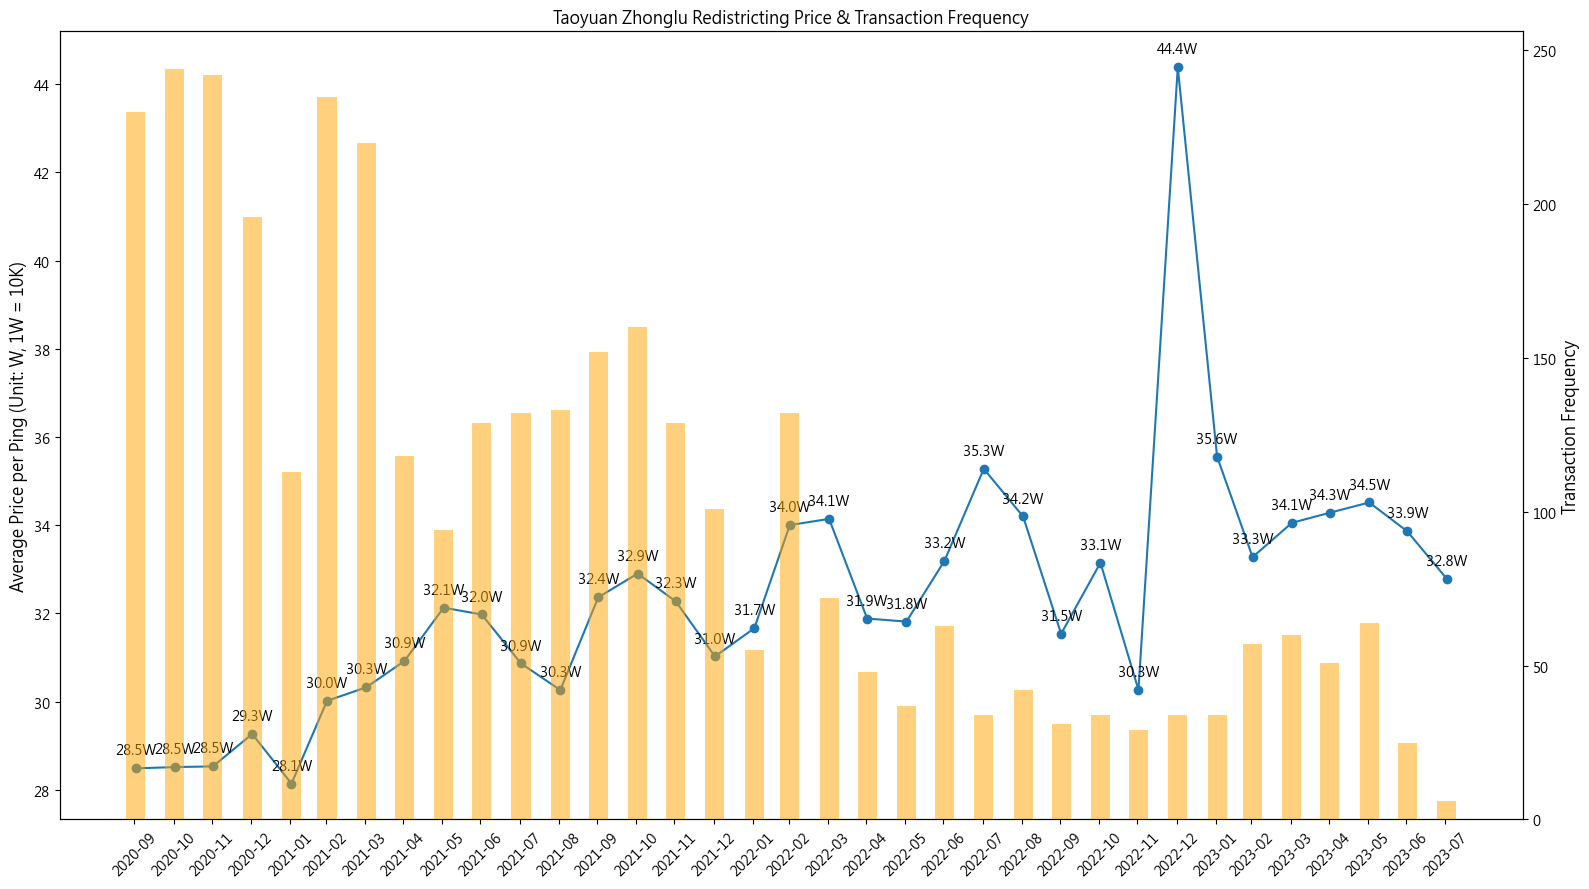

In [153]:
# Convert 'Yearmonth' to datetime
data_deer['Yearmonth'] = pd.to_datetime(data_deer['Yearmonth'].astype(str), errors='coerce')

# Drop rows with missing or NaT values (if needed)
data_deer = data_deer.dropna(subset=['Yearmonth'])

# Continue with the rest of your code...
average_price_per_sqm = data_deer.groupby('Yearmonth')['單價元坪'].mean().reset_index()

# Convert 'Yearmonth' values to numeric
average_price_per_sqm = data_deer.groupby('Yearmonth')['單價元坪'].mean().reset_index()
x_values = sorted(set(average_price_per_sqm['Yearmonth']))
x_values_numeric = date2num(x_values)

# Calculate transaction counts per month
entry_counts = data_deer['Yearmonth'].value_counts().sort_index().reset_index()
entry_counts.columns = ['Yearmonth', 'Transaction Counts']

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(16, 9))

# 繪製平均價格的折線圖
line = ax1.plot(x_values_numeric, average_price_per_sqm['單價元坪'] / 10000, marker='o', label='Average Price')
ax1.set_ylabel('Average Price per Ping (Unit: W, 1W = 10K)', fontsize=12)
ax1.tick_params('y')

# 設定圖表標題和軸標籤
title = 'Taoyuan Zhonglu Redistricting Price & Transaction Frequency'
plt.title(title)

# 設定雙 Y 軸
ax2 = ax1.twinx()
ax2.bar(x_values_numeric, entry_counts['Transaction Counts'], alpha=0.5, color='orange', width=15, label='Transaction Counts')
ax2.set_ylabel('Transaction Frequency', fontsize=12)

# Set the x-axis ticks and labels to display from September 2020 to August 2023
ax1.set_xticks(pd.date_range('2020-09-01', '2023-08-01', freq='M'))
ax1.set_xticklabels([date.strftime('%Y-%m') for date in pd.date_range('2020-09-01', '2023-08-01', freq='M')],
                    rotation=45)

# Add data labels to the line plot
for i, txt in enumerate(average_price_per_sqm['單價元坪'] / 10000):
    ax1.annotate(f'{round(txt, 1)}W', (x_values_numeric[i], txt),
                 textcoords="offset points", xytext=(0, 10), ha='center')

# 顯示圖表
plt.xticks(rotation=45)
plt.tight_layout()

# # save the plot with title named
# path_to_save_file = Path().absolute()/"PNG"/"Redistricting"
# path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
# filename = f'{title}.png'
# full_path = path_to_save_file/filename
# plt.savefig(full_path)

plt.show()


In [154]:
for type in list(property_dict.keys()):
    # Step 1: 篩選出建物型態為住宅大樓的數據
    data_deer_detail = data_deer[data_deer['建物型態'] == type]
    data_deer_detail.loc[:,'總價元'] = data_deer_detail['總價元']/10000
    data_deer_detail.loc[:,'單價元坪'] = data_deer_detail['單價元坪']/10000
    data_deer_detail = data_deer_detail[['總價元', '建物移轉總面積坪', '單價元坪']]
    if data_deer_detail[['總價元', '建物移轉總面積坪', '單價元坪']].isnull().all().all():
        continue  # 如果是，則跳過該類型的輸出
    print(type)
    display(data_deer_detail.describe().round(1))

公寓(5樓含以下無電梯)


,總價元,建物移轉總面積坪,單價元坪
count,91.0,91.0,91.0
mean,584.0,29.0,20.3
std,398.3,13.4,9.1
min,133.0,14.3,8.5
25%,379.5,20.7,14.4
50%,470.0,26.2,18.5
75%,623.0,32.9,24.1
max,3020.0,99.2,66.5


透天厝


,總價元,建物移轉總面積坪,單價元坪
count,124.0,124.0,124.0
mean,2422.5,82.1,36.9
std,2702.9,206.9,23.0
min,239.4,7.1,7.1
25%,1147.5,32.0,25.5
50%,1724.0,57.5,33.5
75%,3309.5,98.4,41.2
max,26800.0,2335.1,218.0


住宅大樓(11層含以上有電梯)


,總價元,建物移轉總面積坪,單價元坪
count,3156.0,3156.0,3156.0
mean,1633.9,55.0,31.6
std,967.2,24.0,6.9
min,100.0,11.5,6.8
25%,1088.0,39.6,27.3
50%,1361.5,49.1,31.1
75%,1858.0,62.9,35.1
max,17700.0,405.0,77.2


華廈(10層含以下有電梯)


,總價元,建物移轉總面積坪,單價元坪
count,165.0,165.0,165.0
mean,1274.8,52.4,24.0
std,1090.4,31.4,6.3
min,220.0,13.9,9.0
25%,738.0,35.7,19.7
50%,960.0,43.6,23.0
75%,1720.0,65.6,28.4
max,11850.0,324.5,49.9


In [156]:
import math

# 初始化一個空的 DataFrame
result_data_deer = pd.DataFrame(columns=['Type', '2020Q4 avg price', '2023Q2 avg price', 'Growth Difference'])

for type in list(property_dict.keys()):
    # Step 1: 篩選出建物型態為住宅大樓的數據
    residential_df = data_bigger[data_bigger['建物型態'] == type]

    # Step 3: 計算2020年第四季和2023年第二季的平均價格
    avg_price_2020_Q4 = residential_df[(residential_df['Year'] == 2020) & (residential_df['Quarter'] == 4)]['單價元坪'].mean() / 10000
    avg_price_2023_Q2 = residential_df[(residential_df['Year'] == 2023) & (residential_df['Quarter'] == 2)]['單價元坪'].mean() / 10000

    # 轉換為小數點兩位
    avg_price_2020_Q4 = round(avg_price_2020_Q4, 2)
    avg_price_2023_Q2 = round(avg_price_2023_Q2, 2)

    # Step 4: 計算成長差異
    if not math.isnan(avg_price_2023_Q2):
        price_growth_difference = ((avg_price_2023_Q2 - avg_price_2020_Q4) / avg_price_2023_Q2) * 100

        # 轉換成百分比，並且保留小數點兩位
        price_growth_difference = round(price_growth_difference, 2)

        # Step 5: 檢查 Growth difference 是否為 NaN，如果不是，加入到 DataFrame
        if not math.isnan(price_growth_difference):
            # 檢查是否為空的 DataFrame
            if result_data_deer.empty:
                result_data_deer = pd.DataFrame([{
                    'Type': property_dict.get(type),
                    '2020Q4 avg price': avg_price_2020_Q4,
                    '2023Q2 avg price': avg_price_2023_Q2,
                    'Growth Difference': f"{price_growth_difference}%"
                }])
            else:
                # 合併非空的 DataFrame
                result_data_deer = pd.concat([result_data_deer, pd.DataFrame([{
                    'Type': property_dict.get(type),
                    '2020Q4 avg price': avg_price_2020_Q4,
                    '2023Q2 avg price': avg_price_2023_Q2,
                    'Growth Difference': f"{price_growth_difference}%"
                }])], ignore_index=True)

# 輸出最終的 DataFrame
result_data_deer = result_data_deer[(result_data_deer['Type'] == 'Residential Building')]# | (result_data_deer['Type'] == 'Mansion') | (result_data_deer['Type'] == 'Villa')]
result_data_deer

,Type,2020Q4 avg price,2023Q2 avg price,Growth Difference
2,Residential Building,31.06,37.88,18.0%


In [141]:
# 針對八德擴大特區作分析
# 要搜尋的多個關鍵字
keywords = ['大明段', '桃鷹路', '大明里', '桃鷹段', '大樹林段', '鳳福段']

# 在"土地位置建物門牌"欄位中找到包含特定關鍵字的資料
data_bade_Tao = data[(data['鄉鎮市區'] == '八德區') | (data['鄉鎮市區'] == '桃園區') ]

# 在"土地位置建物門牌"欄位中找到包含多個關鍵字的資料
data_bade_Tao = data_bade_Tao[data_bade_Tao['土地位置建物門牌'].str.contains('|'.join(keywords), na=False)]
ddata_bade_Tao_detail = data_bade_Tao[['土地移轉總面積平方公尺', '總價元', '主建物面積坪', '土地移轉總面積坪', '建物移轉總面積坪', '單價元坪']]
ddata_bade_Tao_detail.loc[:,'總價元'] = ddata_bade_Tao_detail['總價元'] / 10000
ddata_bade_Tao_detail.loc[:,'單價元坪'] = ddata_bade_Tao_detail['單價元坪'] / 10000

# data_HSR.describe()
ddata_bade_Tao_detail.describe().round(2)


,總價元,主建物面積坪,土地移轉總面積坪,建物移轉總面積坪,單價元坪
count,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN


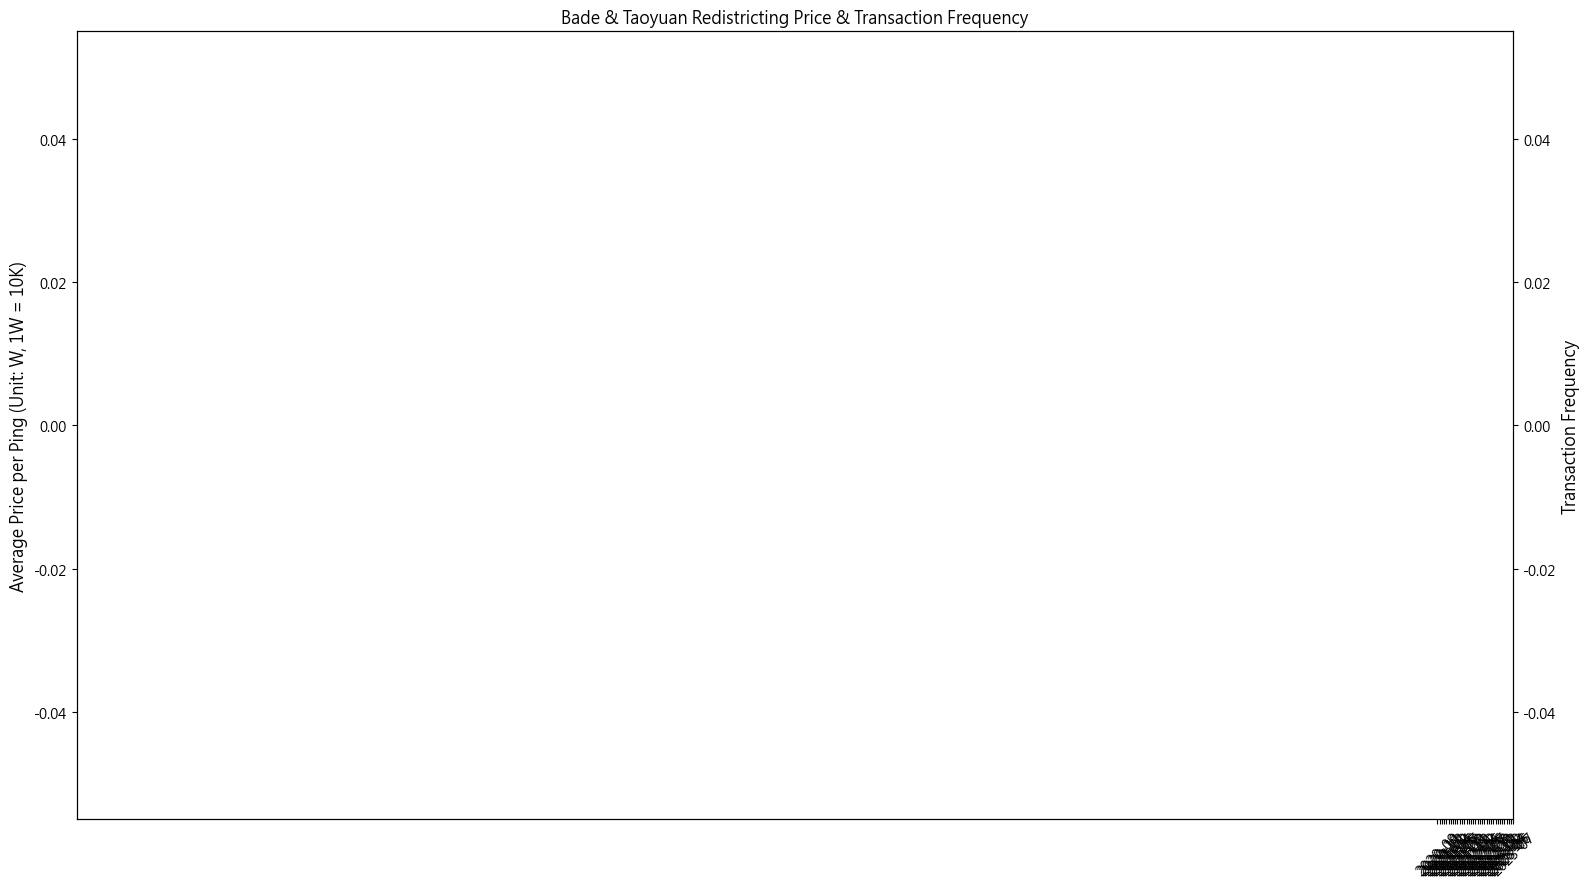

In [142]:
# Convert 'Yearmonth' to datetime
data_bade_Tao['Yearmonth'] = pd.to_datetime(data_bade_Tao['Yearmonth'].astype(str), errors='coerce')

# Drop rows with missing or NaT values (if needed)
data_bade_Tao = data_bade_Tao.dropna(subset=['Yearmonth'])

# Continue with the rest of your code...
average_price_per_sqm = data_bade_Tao.groupby('Yearmonth')['單價元坪'].mean().reset_index()

# Convert 'Yearmonth' values to numeric
average_price_per_sqm = data_bade_Tao.groupby('Yearmonth')['單價元坪'].mean().reset_index()
x_values = sorted(set(average_price_per_sqm['Yearmonth']))
x_values_numeric = date2num(x_values)

# Calculate transaction counts per month
entry_counts = data_bade_Tao['Yearmonth'].value_counts().sort_index().reset_index()
entry_counts.columns = ['Yearmonth', 'Transaction Counts']

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(16, 9))

# 繪製平均價格的折線圖
line = ax1.plot(x_values_numeric, average_price_per_sqm['單價元坪'] / 10000, marker='o', label='Average Price')
ax1.set_ylabel('Average Price per Ping (Unit: W, 1W = 10K)', fontsize=12)
ax1.tick_params('y')

# 設定圖表標題和軸標籤
title = 'Bade & Taoyuan Redistricting Price & Transaction Frequency'
plt.title(title)

# 設定雙 Y 軸
ax2 = ax1.twinx()
ax2.bar(x_values_numeric, entry_counts['Transaction Counts'], alpha=0.5, color='orange', width=15, label='Transaction Counts')
ax2.set_ylabel('Transaction Frequency', fontsize=12)

# Set the x-axis ticks and labels to display from September 2020 to August 2023
ax1.set_xticks(pd.date_range('2020-09-01', '2023-08-01', freq='M'))
ax1.set_xticklabels([date.strftime('%Y-%m') for date in pd.date_range('2020-09-01', '2023-08-01', freq='M')],
                    rotation=45)

# Add data labels to the line plot
for i, txt in enumerate(average_price_per_sqm['單價元坪'] / 10000):
    ax1.annotate(f'{round(txt, 1)}W', (x_values_numeric[i], txt),
                 textcoords="offset points", xytext=(0, 10), ha='center')

# 顯示圖表
plt.xticks(rotation=45)
plt.tight_layout()

# save the plot with title named
path_to_save_file = Path().absolute()/"PNG"/"Redistricting"
path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
filename = f'{title}.png'
full_path = path_to_save_file/filename
plt.savefig(full_path)

plt.show()


In [143]:
# for type in list(property_dict.keys()):
#     # Step 1: 篩選出建物型態為住宅大樓的數據
#     data_bade_Tao_detail = data_bade_Tao[data_bade_Tao['建物型態'] == type]
#     data_bade_Tao_detail.loc[:,'總價元'] = data_bade_Tao_detail['總價元']/10000
#     data_bade_Tao_detail.loc[:,'單價元坪'] = data_bade_Tao_detail['單價元坪']/10000
#     data_bade_Tao_detail = data_bade_Tao_detail[['總價元', '建物移轉總面積坪', '單價元坪']]
#     if data_bade_Tao_detail[['總價元', '建物移轉總面積坪', '單價元坪']].isnull().all().all():
#         continue  # 如果是，則跳過該類型的輸出
#     print(type)
#     display(data_bade_Tao_detail.describe().round(1))


In [144]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

url = 'https://www.numbeo.com/property-investment/rankings_by_country.jsp'
re = requests.get(url)
soup = BeautifulSoup(re.text, 'html.parser')

soup = soup.select('tbody')[0].select('tr')

country_list = []
price_to_income_ratio_list = []

for i in range(len(soup)):
    country = soup[i].select('td[class="cityOrCountryInIndicesTable"]')[0].text
    price_to_income_ratio = soup[i].select('td[style="text-align: right"]')[0].text
    country_list.append(country)
    price_to_income_ratio_list.append(price_to_income_ratio)
    # print(i+1, country, price_to_income_ratio, sep = '/')

df = pd.DataFrame(list(zip(country_list, price_to_income_ratio_list)), columns=['Country', 'Price_to_Income_Ratio'])
df.index = range(1, len(df) + 1)


In [145]:
df = df[(df['Country'] == 'Taiwan') | 
        (df['Country'] == 'Syria') | 
        (df['Country'] == 'Hong Kong (China)') | 
        (df['Country'] == 'Cameroon') | 
        (df['Country'] == 'China') |
        (df['Country'] == 'South Korea') |
        (df['Country'] == 'Indonesia') |
        (df['Country'] == 'Singapore') |
        (df['Country'] == 'Egypt') |
        (df['Country'] == 'Australia') |
        (df['Country'] == 'Japan') |
        (df['Country'] == 'Malaysia') |
        (df['Country'] == 'United Kingdom') |
        (df['Country'] == 'United Arab Emirates') ]
df

,Country,Price_to_Income_Ratio
1,Syria,99.5
2,Hong Kong (China),42.1
3,Cameroon,41.7
6,China,33.0
15,Taiwan,22.1
16,South Korea,20.3
17,Indonesia,19.7
28,Singapore,15.7
53,Egypt,12.5
74,Australia,9.9
